In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import importlib

import seaborn as sns
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

state = 1
np.random.seed(1)


DATA_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/data/'
ROOT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/'
GROUND_PATH = DATA_PATH + '/groundTruth/'
ORI_IMAGE_PATH = DATA_PATH + '/images/'
OUT_IMAGE_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/image/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/model/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/result/'
LOG_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/logs/'


def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(OUT_IMAGE_PATH):
        os.makedirs(OUT_IMAGE_PATH)
    path = os.path.join(OUT_IMAGE_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test_ori.npy')
X_val = np.load(DATA_PATH + 'X_val_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_concat.npy')
y_test = np.load(DATA_PATH + 'y_test_concat.npy')
y_val = np.load(DATA_PATH + 'y_val_concat.npy')
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((200, 320, 480, 3),
 (200, 320, 480, 3),
 (100, 320, 480, 3),
 (200, 320, 480, 1),
 (200, 320, 480, 1),
 (100, 320, 480, 1))

In [4]:
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, add, Activation, Input, \
                            Lambda, MaxPooling2D, concatenate
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.initializers import he_normal, glorot_normal
from keras import backend as K
import tensorflow as tf

from loss_functions.Loss_Functions import cross_entropy_balanced, pixel_error
from my_models.U_Net import u_net_fuse

In [5]:
model_unet_fuse = u_net_fuse(input_shape=(320, 480, 3))
model_unet_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 320, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_1a (Conv2D)                (None, 320, 480, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv_1b (Conv2D)                (None, 320, 480, 16) 2320        conv_1a[0][0]                    
__________________________________________________________________________________________________
pool_1 (Ma

In [7]:
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1, min_lr=1e-5)
checkpointer = ModelCheckpoint('model_UNet_fuse_v1.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse.compile(loss={'o1': cross_entropy_balanced,
                        'o2': cross_entropy_balanced,
                        'o3': cross_entropy_balanced,
                        'o4': cross_entropy_balanced,
                        'o5': cross_entropy_balanced,
                        'ofuse': cross_entropy_balanced,
                        },
                  metrics={'ofuse': pixel_error},
                  optimizer=optimizer)

results = model_unet_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=200, callbacks=callback_list, verbose=2)

Train on 200 samples, validate on 100 samples


Epoch 1/200


Epoch 00001: val_loss improved from inf to 0.39207, saving model to model_UNet_fuse_v1.h5


 - 13s - loss: 0.3703 - o1_loss: 0.0624 - o2_loss: 0.0626 - o3_loss: 0.0626 - o4_loss: 0.0606 - o5_loss: 0.0600 - ofuse_loss: 0.0620 - ofuse_pixel_error: 0.5141 - val_loss: 0.3921 - val_o1_loss: 0.0662 - val_o2_loss: 0.0676 - val_o3_loss: 0.0677 - val_o4_loss: 0.0635 - val_o5_loss: 0.0619 - val_ofuse_loss: 0.0652 - val_ofuse_pixel_error: 0.3679


Epoch 2/200


Epoch 00002: val_loss improved from 0.39207 to 0.39180, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3748 - o1_loss: 0.0638 - o2_loss: 0.0631 - o3_loss: 0.0627 - o4_loss: 0.0629 - o5_loss: 0.0602 - ofuse_loss: 0.0619 - ofuse_pixel_error: 0.3293 - val_loss: 0.3918 - val_o1_loss: 0.0675 - val_o2_loss: 0.0677 - val_o3_loss: 0.0677 - val_o4_loss: 0.0631 - val_o5_loss: 0.0616 - val_ofuse_loss: 0.0641 - val_ofuse_pixel_error: 0.3650


Epoch 3/200


Epoch 00003: val_loss improved from 0.39180 to 0.38619, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3552 - o1_loss: 0.0620 - o2_loss: 0.0625 - o3_loss: 0.0627 - o4_loss: 0.0552 - o5_loss: 0.0545 - ofuse_loss: 0.0582 - ofuse_pixel_error: 0.2677 - val_loss: 0.3862 - val_o1_loss: 0.0675 - val_o2_loss: 0.0675 - val_o3_loss: 0.0676 - val_o4_loss: 0.0614 - val_o5_loss: 0.0603 - val_ofuse_loss: 0.0619 - val_ofuse_pixel_error: 0.3934


Epoch 4/200


Epoch 00004: val_loss improved from 0.38619 to 0.37155, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3479 - o1_loss: 0.0606 - o2_loss: 0.0616 - o3_loss: 0.0623 - o4_loss: 0.0540 - o5_loss: 0.0532 - ofuse_loss: 0.0562 - ofuse_pixel_error: 0.2762 - val_loss: 0.3715 - val_o1_loss: 0.0635 - val_o2_loss: 0.0643 - val_o3_loss: 0.0665 - val_o4_loss: 0.0575 - val_o5_loss: 0.0575 - val_ofuse_loss: 0.0621 - val_ofuse_pixel_error: 0.2644


Epoch 5/200


Epoch 00005: val_loss improved from 0.37155 to 0.36797, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3414 - o1_loss: 0.0583 - o2_loss: 0.0592 - o3_loss: 0.0608 - o4_loss: 0.0540 - o5_loss: 0.0532 - ofuse_loss: 0.0560 - ofuse_pixel_error: 0.2723 - val_loss: 0.3680 - val_o1_loss: 0.0630 - val_o2_loss: 0.0639 - val_o3_loss: 0.0656 - val_o4_loss: 0.0572 - val_o5_loss: 0.0573 - val_ofuse_loss: 0.0610 - val_ofuse_pixel_error: 0.2414


Epoch 6/200


Epoch 00006: val_loss improved from 0.36797 to 0.36699, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3366 - o1_loss: 0.0581 - o2_loss: 0.0584 - o3_loss: 0.0594 - o4_loss: 0.0533 - o5_loss: 0.0522 - ofuse_loss: 0.0552 - ofuse_pixel_error: 0.2572 - val_loss: 0.3670 - val_o1_loss: 0.0651 - val_o2_loss: 0.0644 - val_o3_loss: 0.0663 - val_o4_loss: 0.0564 - val_o5_loss: 0.0566 - val_ofuse_loss: 0.0583 - val_ofuse_pixel_error: 0.2893


Epoch 7/200


Epoch 00007: val_loss did not improve
 - 11s - loss: 0.3271 - o1_loss: 0.0570 - o2_loss: 0.0573 - o3_loss: 0.0571 - o4_loss: 0.0517 - o5_loss: 0.0511 - ofuse_loss: 0.0528 - ofuse_pixel_error: 0.2999 - val_loss: 0.3764 - val_o1_loss: 0.0644 - val_o2_loss: 0.0645 - val_o3_loss: 0.0644 - val_o4_loss: 0.0619 - val_o5_loss: 0.0594 - val_ofuse_loss: 0.0619 - val_ofuse_pixel_error: 0.5348


Epoch 8/200


Epoch 00008: val_loss improved from 0.36699 to 0.35049, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3236 - o1_loss: 0.0574 - o2_loss: 0.0569 - o3_loss: 0.0554 - o4_loss: 0.0512 - o5_loss: 0.0504 - ofuse_loss: 0.0522 - ofuse_pixel_error: 0.2869 - val_loss: 0.3505 - val_o1_loss: 0.0614 - val_o2_loss: 0.0605 - val_o3_loss: 0.0589 - val_o4_loss: 0.0567 - val_o5_loss: 0.0560 - val_ofuse_loss: 0.0570 - val_ofuse_pixel_error: 0.4232


Epoch 9/200


Epoch 00009: val_loss did not improve
 - 11s - loss: 0.3152 - o1_loss: 0.0559 - o2_loss: 0.0554 - o3_loss: 0.0537 - o4_loss: 0.0502 - o5_loss: 0.0498 - ofuse_loss: 0.0504 - ofuse_pixel_error: 0.2872 - val_loss: 0.3531 - val_o1_loss: 0.0618 - val_o2_loss: 0.0615 - val_o3_loss: 0.0602 - val_o4_loss: 0.0558 - val_o5_loss: 0.0567 - val_ofuse_loss: 0.0572 - val_ofuse_pixel_error: 0.3707


Epoch 10/200


Epoch 00010: val_loss improved from 0.35049 to 0.33852, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3093 - o1_loss: 0.0552 - o2_loss: 0.0542 - o3_loss: 0.0519 - o4_loss: 0.0494 - o5_loss: 0.0492 - ofuse_loss: 0.0494 - ofuse_pixel_error: 0.2862 - val_loss: 0.3385 - val_o1_loss: 0.0598 - val_o2_loss: 0.0587 - val_o3_loss: 0.0563 - val_o4_loss: 0.0546 - val_o5_loss: 0.0541 - val_ofuse_loss: 0.0549 - val_ofuse_pixel_error: 0.3834


Epoch 11/200


Epoch 00011: val_loss improved from 0.33852 to 0.33835, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.3032 - o1_loss: 0.0544 - o2_loss: 0.0532 - o3_loss: 0.0506 - o4_loss: 0.0484 - o5_loss: 0.0481 - ofuse_loss: 0.0484 - ofuse_pixel_error: 0.2951 - val_loss: 0.3383 - val_o1_loss: 0.0604 - val_o2_loss: 0.0593 - val_o3_loss: 0.0567 - val_o4_loss: 0.0543 - val_o5_loss: 0.0538 - val_ofuse_loss: 0.0539 - val_ofuse_pixel_error: 0.3343


Epoch 12/200


Epoch 00012: val_loss improved from 0.33835 to 0.33038, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.2981 - o1_loss: 0.0538 - o2_loss: 0.0522 - o3_loss: 0.0496 - o4_loss: 0.0476 - o5_loss: 0.0474 - ofuse_loss: 0.0476 - ofuse_pixel_error: 0.2975 - val_loss: 0.3304 - val_o1_loss: 0.0596 - val_o2_loss: 0.0577 - val_o3_loss: 0.0549 - val_o4_loss: 0.0527 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.0529 - val_ofuse_pixel_error: 0.3618


Epoch 13/200


Epoch 00013: val_loss improved from 0.33038 to 0.32351, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.2905 - o1_loss: 0.0529 - o2_loss: 0.0510 - o3_loss: 0.0481 - o4_loss: 0.0462 - o5_loss: 0.0461 - ofuse_loss: 0.0461 - ofuse_pixel_error: 0.2906 - val_loss: 0.3235 - val_o1_loss: 0.0587 - val_o2_loss: 0.0564 - val_o3_loss: 0.0539 - val_o4_loss: 0.0517 - val_o5_loss: 0.0514 - val_ofuse_loss: 0.0514 - val_ofuse_pixel_error: 0.2787


Epoch 14/200


Epoch 00014: val_loss did not improve
 - 11s - loss: 0.2905 - o1_loss: 0.0528 - o2_loss: 0.0508 - o3_loss: 0.0482 - o4_loss: 0.0464 - o5_loss: 0.0462 - ofuse_loss: 0.0461 - ofuse_pixel_error: 0.2861 - val_loss: 0.3378 - val_o1_loss: 0.0606 - val_o2_loss: 0.0598 - val_o3_loss: 0.0562 - val_o4_loss: 0.0543 - val_o5_loss: 0.0532 - val_ofuse_loss: 0.0537 - val_ofuse_pixel_error: 0.2524


Epoch 15/200


Epoch 00015: val_loss did not improve
 - 11s - loss: 0.2869 - o1_loss: 0.0528 - o2_loss: 0.0505 - o3_loss: 0.0475 - o4_loss: 0.0455 - o5_loss: 0.0453 - ofuse_loss: 0.0452 - ofuse_pixel_error: 0.2808 - val_loss: 0.3237 - val_o1_loss: 0.0585 - val_o2_loss: 0.0571 - val_o3_loss: 0.0534 - val_o4_loss: 0.0517 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.0513 - val_ofuse_pixel_error: 0.3035


Epoch 16/200


Epoch 00016: val_loss improved from 0.32351 to 0.32035, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.2803 - o1_loss: 0.0516 - o2_loss: 0.0490 - o3_loss: 0.0460 - o4_loss: 0.0447 - o5_loss: 0.0446 - ofuse_loss: 0.0445 - ofuse_pixel_error: 0.2894 - val_loss: 0.3204 - val_o1_loss: 0.0580 - val_o2_loss: 0.0554 - val_o3_loss: 0.0528 - val_o4_loss: 0.0514 - val_o5_loss: 0.0514 - val_ofuse_loss: 0.0513 - val_ofuse_pixel_error: 0.2719


Epoch 17/200


Epoch 00017: val_loss did not improve
 - 11s - loss: 0.2811 - o1_loss: 0.0516 - o2_loss: 0.0491 - o3_loss: 0.0462 - o4_loss: 0.0448 - o5_loss: 0.0447 - ofuse_loss: 0.0447 - ofuse_pixel_error: 0.2806 - val_loss: 0.3222 - val_o1_loss: 0.0582 - val_o2_loss: 0.0559 - val_o3_loss: 0.0533 - val_o4_loss: 0.0516 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.0516 - val_ofuse_pixel_error: 0.2938


Epoch 18/200


Epoch 00018: val_loss improved from 0.32035 to 0.31790, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.2747 - o1_loss: 0.0505 - o2_loss: 0.0480 - o3_loss: 0.0452 - o4_loss: 0.0438 - o5_loss: 0.0437 - ofuse_loss: 0.0435 - ofuse_pixel_error: 0.2777 - val_loss: 0.3179 - val_o1_loss: 0.0581 - val_o2_loss: 0.0558 - val_o3_loss: 0.0523 - val_o4_loss: 0.0505 - val_o5_loss: 0.0504 - val_ofuse_loss: 0.0508 - val_ofuse_pixel_error: 0.3010


Epoch 19/200


Epoch 00019: val_loss did not improve
 - 11s - loss: 0.2741 - o1_loss: 0.0504 - o2_loss: 0.0477 - o3_loss: 0.0449 - o4_loss: 0.0438 - o5_loss: 0.0438 - ofuse_loss: 0.0435 - ofuse_pixel_error: 0.2698 - val_loss: 0.3206 - val_o1_loss: 0.0577 - val_o2_loss: 0.0560 - val_o3_loss: 0.0527 - val_o4_loss: 0.0514 - val_o5_loss: 0.0513 - val_ofuse_loss: 0.0516 - val_ofuse_pixel_error: 0.3019


Epoch 20/200


Epoch 00020: val_loss did not improve
 - 11s - loss: 0.2754 - o1_loss: 0.0506 - o2_loss: 0.0479 - o3_loss: 0.0453 - o4_loss: 0.0439 - o5_loss: 0.0440 - ofuse_loss: 0.0437 - ofuse_pixel_error: 0.2715 - val_loss: 0.3206 - val_o1_loss: 0.0584 - val_o2_loss: 0.0558 - val_o3_loss: 0.0527 - val_o4_loss: 0.0514 - val_o5_loss: 0.0509 - val_ofuse_loss: 0.0514 - val_ofuse_pixel_error: 0.4066


Epoch 21/200


Epoch 00021: val_loss improved from 0.31790 to 0.31755, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.2711 - o1_loss: 0.0501 - o2_loss: 0.0472 - o3_loss: 0.0442 - o4_loss: 0.0433 - o5_loss: 0.0433 - ofuse_loss: 0.0431 - ofuse_pixel_error: 0.2707 - val_loss: 0.3175 - val_o1_loss: 0.0573 - val_o2_loss: 0.0548 - val_o3_loss: 0.0522 - val_o4_loss: 0.0513 - val_o5_loss: 0.0512 - val_ofuse_loss: 0.0507 - val_ofuse_pixel_error: 0.3384


Epoch 22/200


Epoch 00022: val_loss did not improve
 - 11s - loss: 0.2678 - o1_loss: 0.0495 - o2_loss: 0.0465 - o3_loss: 0.0438 - o4_loss: 0.0428 - o5_loss: 0.0427 - ofuse_loss: 0.0425 - ofuse_pixel_error: 0.2687 - val_loss: 0.3202 - val_o1_loss: 0.0582 - val_o2_loss: 0.0558 - val_o3_loss: 0.0526 - val_o4_loss: 0.0511 - val_o5_loss: 0.0512 - val_ofuse_loss: 0.0513 - val_ofuse_pixel_error: 0.2329


Epoch 23/200


Epoch 00023: val_loss improved from 0.31755 to 0.31517, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.2651 - o1_loss: 0.0490 - o2_loss: 0.0460 - o3_loss: 0.0433 - o4_loss: 0.0423 - o5_loss: 0.0423 - ofuse_loss: 0.0421 - ofuse_pixel_error: 0.2653 - val_loss: 0.3152 - val_o1_loss: 0.0571 - val_o2_loss: 0.0548 - val_o3_loss: 0.0518 - val_o4_loss: 0.0505 - val_o5_loss: 0.0504 - val_ofuse_loss: 0.0505 - val_ofuse_pixel_error: 0.2667


Epoch 24/200


Epoch 00024: val_loss did not improve
 - 11s - loss: 0.2625 - o1_loss: 0.0487 - o2_loss: 0.0456 - o3_loss: 0.0428 - o4_loss: 0.0418 - o5_loss: 0.0419 - ofuse_loss: 0.0417 - ofuse_pixel_error: 0.2574 - val_loss: 0.3187 - val_o1_loss: 0.0588 - val_o2_loss: 0.0560 - val_o3_loss: 0.0522 - val_o4_loss: 0.0505 - val_o5_loss: 0.0505 - val_ofuse_loss: 0.0507 - val_ofuse_pixel_error: 0.2254


Epoch 25/200


Epoch 00025: val_loss did not improve
 - 11s - loss: 0.2633 - o1_loss: 0.0489 - o2_loss: 0.0458 - o3_loss: 0.0428 - o4_loss: 0.0420 - o5_loss: 0.0421 - ofuse_loss: 0.0418 - ofuse_pixel_error: 0.2701 - val_loss: 0.3206 - val_o1_loss: 0.0572 - val_o2_loss: 0.0545 - val_o3_loss: 0.0528 - val_o4_loss: 0.0520 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.0517 - val_ofuse_pixel_error: 0.1798


Epoch 26/200


Epoch 00026: val_loss did not improve
 - 11s - loss: 0.2613 - o1_loss: 0.0483 - o2_loss: 0.0454 - o3_loss: 0.0426 - o4_loss: 0.0417 - o5_loss: 0.0418 - ofuse_loss: 0.0415 - ofuse_pixel_error: 0.2591 - val_loss: 0.3262 - val_o1_loss: 0.0575 - val_o2_loss: 0.0560 - val_o3_loss: 0.0537 - val_o4_loss: 0.0530 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.0531 - val_ofuse_pixel_error: 0.2302


Epoch 27/200


Epoch 00027: val_loss did not improve
 - 11s - loss: 0.2528 - o1_loss: 0.0473 - o2_loss: 0.0440 - o3_loss: 0.0412 - o4_loss: 0.0402 - o5_loss: 0.0401 - ofuse_loss: 0.0400 - ofuse_pixel_error: 0.2570 - val_loss: 0.3191 - val_o1_loss: 0.0585 - val_o2_loss: 0.0554 - val_o3_loss: 0.0525 - val_o4_loss: 0.0508 - val_o5_loss: 0.0507 - val_ofuse_loss: 0.0510 - val_ofuse_pixel_error: 0.2785


Epoch 28/200


Epoch 00028: val_loss did not improve
 - 11s - loss: 0.2546 - o1_loss: 0.0477 - o2_loss: 0.0441 - o3_loss: 0.0415 - o4_loss: 0.0405 - o5_loss: 0.0405 - ofuse_loss: 0.0403 - ofuse_pixel_error: 0.2528 - val_loss: 0.3182 - val_o1_loss: 0.0573 - val_o2_loss: 0.0550 - val_o3_loss: 0.0526 - val_o4_loss: 0.0512 - val_o5_loss: 0.0511 - val_ofuse_loss: 0.0510 - val_ofuse_pixel_error: 0.2354


Epoch 29/200


Epoch 00029: val_loss did not improve
 - 11s - loss: 0.2515 - o1_loss: 0.0471 - o2_loss: 0.0435 - o3_loss: 0.0408 - o4_loss: 0.0400 - o5_loss: 0.0401 - ofuse_loss: 0.0399 - ofuse_pixel_error: 0.2568 - val_loss: 0.3206 - val_o1_loss: 0.0583 - val_o2_loss: 0.0556 - val_o3_loss: 0.0531 - val_o4_loss: 0.0513 - val_o5_loss: 0.0510 - val_ofuse_loss: 0.0514 - val_ofuse_pixel_error: 0.2988


Epoch 30/200


Epoch 00030: val_loss improved from 0.31517 to 0.31468, saving model to model_UNet_fuse_v1.h5
 - 11s - loss: 0.2485 - o1_loss: 0.0469 - o2_loss: 0.0431 - o3_loss: 0.0404 - o4_loss: 0.0394 - o5_loss: 0.0394 - ofuse_loss: 0.0393 - ofuse_pixel_error: 0.2571 - val_loss: 0.3147 - val_o1_loss: 0.0569 - val_o2_loss: 0.0544 - val_o3_loss: 0.0517 - val_o4_loss: 0.0506 - val_o5_loss: 0.0506 - val_ofuse_loss: 0.0504 - val_ofuse_pixel_error: 0.2646


Epoch 31/200


Epoch 00031: val_loss did not improve
 - 11s - loss: 0.2445 - o1_loss: 0.0465 - o2_loss: 0.0423 - o3_loss: 0.0395 - o4_loss: 0.0387 - o5_loss: 0.0388 - ofuse_loss: 0.0386 - ofuse_pixel_error: 0.2506 - val_loss: 0.3184 - val_o1_loss: 0.0573 - val_o2_loss: 0.0552 - val_o3_loss: 0.0526 - val_o4_loss: 0.0511 - val_o5_loss: 0.0510 - val_ofuse_loss: 0.0513 - val_ofuse_pixel_error: 0.2803


Epoch 32/200


Epoch 00032: val_loss did not improve
 - 11s - loss: 0.2402 - o1_loss: 0.0461 - o2_loss: 0.0417 - o3_loss: 0.0388 - o4_loss: 0.0379 - o5_loss: 0.0380 - ofuse_loss: 0.0378 - ofuse_pixel_error: 0.2439 - val_loss: 0.3321 - val_o1_loss: 0.0587 - val_o2_loss: 0.0573 - val_o3_loss: 0.0552 - val_o4_loss: 0.0536 - val_o5_loss: 0.0535 - val_ofuse_loss: 0.0538 - val_ofuse_pixel_error: 0.2443


Epoch 33/200


Epoch 00033: val_loss did not improve
 - 11s - loss: 0.2329 - o1_loss: 0.0455 - o2_loss: 0.0404 - o3_loss: 0.0375 - o4_loss: 0.0365 - o5_loss: 0.0366 - ofuse_loss: 0.0365 - ofuse_pixel_error: 0.2435 - val_loss: 0.3531 - val_o1_loss: 0.0591 - val_o2_loss: 0.0601 - val_o3_loss: 0.0586 - val_o4_loss: 0.0584 - val_o5_loss: 0.0587 - val_ofuse_loss: 0.0583 - val_ofuse_pixel_error: 0.2174


Epoch 34/200


Epoch 00034: val_loss did not improve
 - 11s - loss: 0.2335 - o1_loss: 0.0454 - o2_loss: 0.0405 - o3_loss: 0.0376 - o4_loss: 0.0367 - o5_loss: 0.0368 - ofuse_loss: 0.0366 - ofuse_pixel_error: 0.2417 - val_loss: 0.3298 - val_o1_loss: 0.0580 - val_o2_loss: 0.0569 - val_o3_loss: 0.0549 - val_o4_loss: 0.0534 - val_o5_loss: 0.0533 - val_ofuse_loss: 0.0533 - val_ofuse_pixel_error: 0.2852


Epoch 35/200


Epoch 00035: val_loss did not improve
 - 11s - loss: 0.2277 - o1_loss: 0.0449 - o2_loss: 0.0395 - o3_loss: 0.0365 - o4_loss: 0.0356 - o5_loss: 0.0356 - ofuse_loss: 0.0355 - ofuse_pixel_error: 0.2418 - val_loss: 0.3316 - val_o1_loss: 0.0588 - val_o2_loss: 0.0581 - val_o3_loss: 0.0556 - val_o4_loss: 0.0533 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.0532 - val_ofuse_pixel_error: 0.2515


Epoch 36/200


Epoch 00036: val_loss did not improve
 - 11s - loss: 0.2201 - o1_loss: 0.0440 - o2_loss: 0.0383 - o3_loss: 0.0351 - o4_loss: 0.0342 - o5_loss: 0.0343 - ofuse_loss: 0.0341 - ofuse_pixel_error: 0.2348 - val_loss: 0.3447 - val_o1_loss: 0.0590 - val_o2_loss: 0.0602 - val_o3_loss: 0.0582 - val_o4_loss: 0.0559 - val_o5_loss: 0.0556 - val_ofuse_loss: 0.0558 - val_ofuse_pixel_error: 0.2133


Epoch 37/200


Epoch 00037: val_loss did not improve
 - 11s - loss: 0.2185 - o1_loss: 0.0438 - o2_loss: 0.0379 - o3_loss: 0.0348 - o4_loss: 0.0340 - o5_loss: 0.0341 - ofuse_loss: 0.0339 - ofuse_pixel_error: 0.2274 - val_loss: 0.3530 - val_o1_loss: 0.0597 - val_o2_loss: 0.0611 - val_o3_loss: 0.0596 - val_o4_loss: 0.0578 - val_o5_loss: 0.0571 - val_ofuse_loss: 0.0577 - val_ofuse_pixel_error: 0.1970


Epoch 38/200


Epoch 00038: val_loss did not improve
 - 11s - loss: 0.2121 - o1_loss: 0.0435 - o2_loss: 0.0368 - o3_loss: 0.0336 - o4_loss: 0.0328 - o5_loss: 0.0329 - ofuse_loss: 0.0327 - ofuse_pixel_error: 0.2253 - val_loss: 0.3638 - val_o1_loss: 0.0588 - val_o2_loss: 0.0629 - val_o3_loss: 0.0616 - val_o4_loss: 0.0600 - val_o5_loss: 0.0603 - val_ofuse_loss: 0.0601 - val_ofuse_pixel_error: 0.2481


Epoch 39/200


Epoch 00039: val_loss did not improve
 - 11s - loss: 0.2133 - o1_loss: 0.0438 - o2_loss: 0.0371 - o3_loss: 0.0337 - o4_loss: 0.0329 - o5_loss: 0.0330 - ofuse_loss: 0.0328 - ofuse_pixel_error: 0.2272 - val_loss: 0.3625 - val_o1_loss: 0.0604 - val_o2_loss: 0.0634 - val_o3_loss: 0.0613 - val_o4_loss: 0.0593 - val_o5_loss: 0.0587 - val_ofuse_loss: 0.0593 - val_ofuse_pixel_error: 0.2510


Epoch 40/200


Epoch 00040: val_loss did not improve
 - 11s - loss: 0.2164 - o1_loss: 0.0442 - o2_loss: 0.0376 - o3_loss: 0.0344 - o4_loss: 0.0334 - o5_loss: 0.0335 - ofuse_loss: 0.0333 - ofuse_pixel_error: 0.2266 - val_loss: 0.3508 - val_o1_loss: 0.0600 - val_o2_loss: 0.0622 - val_o3_loss: 0.0582 - val_o4_loss: 0.0568 - val_o5_loss: 0.0565 - val_ofuse_loss: 0.0570 - val_ofuse_pixel_error: 0.2397


Epoch 41/200


Epoch 00041: val_loss did not improve
 - 11s - loss: 0.1987 - o1_loss: 0.0426 - o2_loss: 0.0345 - o3_loss: 0.0310 - o4_loss: 0.0302 - o5_loss: 0.0303 - ofuse_loss: 0.0301 - ofuse_pixel_error: 0.2187 - val_loss: 0.4610 - val_o1_loss: 0.0646 - val_o2_loss: 0.0775 - val_o3_loss: 0.0796 - val_o4_loss: 0.0799 - val_o5_loss: 0.0794 - val_ofuse_loss: 0.0800 - val_ofuse_pixel_error: 0.1850


Epoch 42/200


Epoch 00042: val_loss did not improve
 - 11s - loss: 0.1956 - o1_loss: 0.0423 - o2_loss: 0.0341 - o3_loss: 0.0304 - o4_loss: 0.0296 - o5_loss: 0.0297 - ofuse_loss: 0.0295 - ofuse_pixel_error: 0.2120 - val_loss: 0.4464 - val_o1_loss: 0.0623 - val_o2_loss: 0.0719 - val_o3_loss: 0.0789 - val_o4_loss: 0.0781 - val_o5_loss: 0.0779 - val_ofuse_loss: 0.0774 - val_ofuse_pixel_error: 0.1745


Epoch 43/200


Epoch 00043: val_loss did not improve
 - 11s - loss: 0.1925 - o1_loss: 0.0419 - o2_loss: 0.0333 - o3_loss: 0.0299 - o4_loss: 0.0291 - o5_loss: 0.0293 - ofuse_loss: 0.0290 - ofuse_pixel_error: 0.2067 - val_loss: 0.4282 - val_o1_loss: 0.0635 - val_o2_loss: 0.0746 - val_o3_loss: 0.0745 - val_o4_loss: 0.0723 - val_o5_loss: 0.0710 - val_ofuse_loss: 0.0723 - val_ofuse_pixel_error: 0.2142


Epoch 44/200


Epoch 00044: val_loss did not improve
 - 11s - loss: 0.1831 - o1_loss: 0.0411 - o2_loss: 0.0319 - o3_loss: 0.0282 - o4_loss: 0.0274 - o5_loss: 0.0274 - ofuse_loss: 0.0273 - ofuse_pixel_error: 0.2049 - val_loss: 0.5199 - val_o1_loss: 0.0637 - val_o2_loss: 0.0843 - val_o3_loss: 0.0907 - val_o4_loss: 0.0937 - val_o5_loss: 0.0940 - val_ofuse_loss: 0.0936 - val_ofuse_pixel_error: 0.1786


Epoch 45/200


Epoch 00045: val_loss did not improve
 - 10s - loss: 0.1761 - o1_loss: 0.0406 - o2_loss: 0.0308 - o3_loss: 0.0268 - o4_loss: 0.0260 - o5_loss: 0.0260 - ofuse_loss: 0.0259 - ofuse_pixel_error: 0.1916 - val_loss: 0.5425 - val_o1_loss: 0.0676 - val_o2_loss: 0.0900 - val_o3_loss: 0.0981 - val_o4_loss: 0.0963 - val_o5_loss: 0.0947 - val_ofuse_loss: 0.0958 - val_ofuse_pixel_error: 0.1799


Epoch 46/200


Epoch 00046: val_loss did not improve
 - 11s - loss: 0.1723 - o1_loss: 0.0401 - o2_loss: 0.0301 - o3_loss: 0.0262 - o4_loss: 0.0253 - o5_loss: 0.0254 - ofuse_loss: 0.0252 - ofuse_pixel_error: 0.1926 - val_loss: 0.5551 - val_o1_loss: 0.0657 - val_o2_loss: 0.0923 - val_o3_loss: 0.0984 - val_o4_loss: 0.1005 - val_o5_loss: 0.0984 - val_ofuse_loss: 0.0998 - val_ofuse_pixel_error: 0.1740


Epoch 47/200


Epoch 00047: val_loss did not improve
 - 10s - loss: 0.1642 - o1_loss: 0.0392 - o2_loss: 0.0288 - o3_loss: 0.0247 - o4_loss: 0.0239 - o5_loss: 0.0239 - ofuse_loss: 0.0238 - ofuse_pixel_error: 0.1853 - val_loss: 0.5614 - val_o1_loss: 0.0676 - val_o2_loss: 0.0921 - val_o3_loss: 0.0998 - val_o4_loss: 0.1017 - val_o5_loss: 0.0994 - val_ofuse_loss: 0.1009 - val_ofuse_pixel_error: 0.1910


Epoch 48/200


Epoch 00048: val_loss did not improve
 - 10s - loss: 0.1604 - o1_loss: 0.0390 - o2_loss: 0.0282 - o3_loss: 0.0240 - o4_loss: 0.0231 - o5_loss: 0.0232 - ofuse_loss: 0.0230 - ofuse_pixel_error: 0.1803 - val_loss: 0.6589 - val_o1_loss: 0.0665 - val_o2_loss: 0.1020 - val_o3_loss: 0.1178 - val_o4_loss: 0.1250 - val_o5_loss: 0.1239 - val_ofuse_loss: 0.1237 - val_ofuse_pixel_error: 0.1605


Epoch 49/200


Epoch 00049: val_loss did not improve
 - 10s - loss: 0.1588 - o1_loss: 0.0388 - o2_loss: 0.0279 - o3_loss: 0.0237 - o4_loss: 0.0228 - o5_loss: 0.0229 - ofuse_loss: 0.0227 - ofuse_pixel_error: 0.1784 - val_loss: 0.5995 - val_o1_loss: 0.0699 - val_o2_loss: 0.0981 - val_o3_loss: 0.1050 - val_o4_loss: 0.1091 - val_o5_loss: 0.1084 - val_ofuse_loss: 0.1090 - val_ofuse_pixel_error: 0.2340


Epoch 50/200


Epoch 00050: val_loss did not improve
 - 10s - loss: 0.1576 - o1_loss: 0.0388 - o2_loss: 0.0278 - o3_loss: 0.0234 - o4_loss: 0.0226 - o5_loss: 0.0226 - ofuse_loss: 0.0225 - ofuse_pixel_error: 0.1733 - val_loss: 0.6456 - val_o1_loss: 0.0656 - val_o2_loss: 0.1009 - val_o3_loss: 0.1147 - val_o4_loss: 0.1218 - val_o5_loss: 0.1213 - val_ofuse_loss: 0.1212 - val_ofuse_pixel_error: 0.1856


Epoch 51/200


Epoch 00051: val_loss did not improve
 - 10s - loss: 0.1566 - o1_loss: 0.0385 - o2_loss: 0.0276 - o3_loss: 0.0233 - o4_loss: 0.0224 - o5_loss: 0.0225 - ofuse_loss: 0.0223 - ofuse_pixel_error: 0.1758 - val_loss: 0.7409 - val_o1_loss: 0.0713 - val_o2_loss: 0.1125 - val_o3_loss: 0.1341 - val_o4_loss: 0.1425 - val_o5_loss: 0.1395 - val_ofuse_loss: 0.1409 - val_ofuse_pixel_error: 0.1341


Epoch 52/200


Epoch 00052: val_loss did not improve
 - 10s - loss: 0.1531 - o1_loss: 0.0382 - o2_loss: 0.0270 - o3_loss: 0.0226 - o4_loss: 0.0218 - o5_loss: 0.0218 - ofuse_loss: 0.0217 - ofuse_pixel_error: 0.1678 - val_loss: 0.6803 - val_o1_loss: 0.0691 - val_o2_loss: 0.1069 - val_o3_loss: 0.1243 - val_o4_loss: 0.1279 - val_o5_loss: 0.1253 - val_ofuse_loss: 0.1267 - val_ofuse_pixel_error: 0.1723


Epoch 53/200


Epoch 00053: val_loss did not improve
 - 10s - loss: 0.1503 - o1_loss: 0.0378 - o2_loss: 0.0266 - o3_loss: 0.0221 - o4_loss: 0.0213 - o5_loss: 0.0214 - ofuse_loss: 0.0212 - ofuse_pixel_error: 0.1691 - val_loss: 0.8364 - val_o1_loss: 0.0723 - val_o2_loss: 0.1248 - val_o3_loss: 0.1542 - val_o4_loss: 0.1631 - val_o5_loss: 0.1606 - val_ofuse_loss: 0.1614 - val_ofuse_pixel_error: 0.1393


Epoch 54/200


Epoch 00054: val_loss did not improve
 - 10s - loss: 0.1483 - o1_loss: 0.0376 - o2_loss: 0.0263 - o3_loss: 0.0217 - o4_loss: 0.0209 - o5_loss: 0.0210 - ofuse_loss: 0.0208 - ofuse_pixel_error: 0.1645 - val_loss: 0.8210 - val_o1_loss: 0.0731 - val_o2_loss: 0.1284 - val_o3_loss: 0.1498 - val_o4_loss: 0.1575 - val_o5_loss: 0.1555 - val_ofuse_loss: 0.1566 - val_ofuse_pixel_error: 0.1542


Epoch 55/200


Epoch 00055: val_loss did not improve
 - 10s - loss: 0.1437 - o1_loss: 0.0370 - o2_loss: 0.0256 - o3_loss: 0.0210 - o4_loss: 0.0201 - o5_loss: 0.0201 - ofuse_loss: 0.0200 - ofuse_pixel_error: 0.1594 - val_loss: 0.8233 - val_o1_loss: 0.0783 - val_o2_loss: 0.1299 - val_o3_loss: 0.1496 - val_o4_loss: 0.1560 - val_o5_loss: 0.1541 - val_ofuse_loss: 0.1554 - val_ofuse_pixel_error: 0.1375


Epoch 56/200


Epoch 00056: val_loss did not improve
 - 10s - loss: 0.1431 - o1_loss: 0.0371 - o2_loss: 0.0255 - o3_loss: 0.0207 - o4_loss: 0.0199 - o5_loss: 0.0200 - ofuse_loss: 0.0198 - ofuse_pixel_error: 0.1566 - val_loss: 0.8085 - val_o1_loss: 0.0719 - val_o2_loss: 0.1259 - val_o3_loss: 0.1491 - val_o4_loss: 0.1553 - val_o5_loss: 0.1524 - val_ofuse_loss: 0.1540 - val_ofuse_pixel_error: 0.1588


Epoch 57/200


Epoch 00057: val_loss did not improve
 - 10s - loss: 0.1449 - o1_loss: 0.0370 - o2_loss: 0.0257 - o3_loss: 0.0212 - o4_loss: 0.0204 - o5_loss: 0.0204 - ofuse_loss: 0.0203 - ofuse_pixel_error: 0.1614 - val_loss: 0.9120 - val_o1_loss: 0.0747 - val_o2_loss: 0.1356 - val_o3_loss: 0.1674 - val_o4_loss: 0.1793 - val_o5_loss: 0.1770 - val_ofuse_loss: 0.1780 - val_ofuse_pixel_error: 0.1325


Epoch 58/200


Epoch 00058: val_loss did not improve
 - 10s - loss: 0.1401 - o1_loss: 0.0366 - o2_loss: 0.0251 - o3_loss: 0.0203 - o4_loss: 0.0194 - o5_loss: 0.0194 - ofuse_loss: 0.0193 - ofuse_pixel_error: 0.1519 - val_loss: 0.8208 - val_o1_loss: 0.0740 - val_o2_loss: 0.1301 - val_o3_loss: 0.1499 - val_o4_loss: 0.1573 - val_o5_loss: 0.1535 - val_ofuse_loss: 0.1561 - val_ofuse_pixel_error: 0.1503


Epoch 59/200


Epoch 00059: val_loss did not improve
 - 10s - loss: 0.1408 - o1_loss: 0.0365 - o2_loss: 0.0252 - o3_loss: 0.0204 - o4_loss: 0.0196 - o5_loss: 0.0197 - ofuse_loss: 0.0195 - ofuse_pixel_error: 0.1563 - val_loss: 0.9638 - val_o1_loss: 0.0754 - val_o2_loss: 0.1463 - val_o3_loss: 0.1805 - val_o4_loss: 0.1896 - val_o5_loss: 0.1845 - val_ofuse_loss: 0.1875 - val_ofuse_pixel_error: 0.1112


Epoch 60/200


Epoch 00060: val_loss did not improve
 - 11s - loss: 0.1689 - o1_loss: 0.0395 - o2_loss: 0.0297 - o3_loss: 0.0256 - o4_loss: 0.0247 - o5_loss: 0.0248 - ofuse_loss: 0.0246 - ofuse_pixel_error: 0.1760 - val_loss: 0.6547 - val_o1_loss: 0.0727 - val_o2_loss: 0.1275 - val_o3_loss: 0.1191 - val_o4_loss: 0.1123 - val_o5_loss: 0.1093 - val_ofuse_loss: 0.1138 - val_ofuse_pixel_error: 0.1289


Epoch 61/200


Epoch 00061: val_loss did not improve
 - 10s - loss: 0.1496 - o1_loss: 0.0375 - o2_loss: 0.0266 - o3_loss: 0.0220 - o4_loss: 0.0212 - o5_loss: 0.0212 - ofuse_loss: 0.0211 - ofuse_pixel_error: 0.1632 - val_loss: 0.7905 - val_o1_loss: 0.0742 - val_o2_loss: 0.1310 - val_o3_loss: 0.1440 - val_o4_loss: 0.1484 - val_o5_loss: 0.1450 - val_ofuse_loss: 0.1480 - val_ofuse_pixel_error: 0.1453


Epoch 62/200


Epoch 00062: val_loss did not improve
 - 10s - loss: 0.1399 - o1_loss: 0.0366 - o2_loss: 0.0251 - o3_loss: 0.0202 - o4_loss: 0.0193 - o5_loss: 0.0194 - ofuse_loss: 0.0192 - ofuse_pixel_error: 0.1526 - val_loss: 0.8198 - val_o1_loss: 0.0767 - val_o2_loss: 0.1315 - val_o3_loss: 0.1476 - val_o4_loss: 0.1552 - val_o5_loss: 0.1536 - val_ofuse_loss: 0.1552 - val_ofuse_pixel_error: 0.1495


Epoch 63/200


Epoch 00063: val_loss did not improve
 - 10s - loss: 0.1325 - o1_loss: 0.0354 - o2_loss: 0.0239 - o3_loss: 0.0190 - o4_loss: 0.0181 - o5_loss: 0.0181 - ofuse_loss: 0.0180 - ofuse_pixel_error: 0.1468 - val_loss: 0.8859 - val_o1_loss: 0.0772 - val_o2_loss: 0.1386 - val_o3_loss: 0.1600 - val_o4_loss: 0.1704 - val_o5_loss: 0.1693 - val_ofuse_loss: 0.1703 - val_ofuse_pixel_error: 0.1487


Epoch 64/200


Epoch 00064: val_loss did not improve
 - 9s - loss: 0.1328 - o1_loss: 0.0356 - o2_loss: 0.0240 - o3_loss: 0.0189 - o4_loss: 0.0181 - o5_loss: 0.0181 - ofuse_loss: 0.0180 - ofuse_pixel_error: 0.1435 - val_loss: 1.0421 - val_o1_loss: 0.0839 - val_o2_loss: 0.1635 - val_o3_loss: 0.1910 - val_o4_loss: 0.2025 - val_o5_loss: 0.1994 - val_ofuse_loss: 0.2018 - val_ofuse_pixel_error: 0.1184


Epoch 65/200


Epoch 00065: val_loss did not improve
 - 9s - loss: 0.1274 - o1_loss: 0.0348 - o2_loss: 0.0232 - o3_loss: 0.0181 - o4_loss: 0.0172 - o5_loss: 0.0172 - ofuse_loss: 0.0170 - ofuse_pixel_error: 0.1386 - val_loss: 0.9816 - val_o1_loss: 0.0790 - val_o2_loss: 0.1474 - val_o3_loss: 0.1812 - val_o4_loss: 0.1937 - val_o5_loss: 0.1884 - val_ofuse_loss: 0.1919 - val_ofuse_pixel_error: 0.1426


Epoch 66/200


Epoch 00066: val_loss did not improve
 - 9s - loss: 0.1268 - o1_loss: 0.0347 - o2_loss: 0.0232 - o3_loss: 0.0179 - o4_loss: 0.0170 - o5_loss: 0.0170 - ofuse_loss: 0.0169 - ofuse_pixel_error: 0.1381 - val_loss: 0.9670 - val_o1_loss: 0.0765 - val_o2_loss: 0.1471 - val_o3_loss: 0.1785 - val_o4_loss: 0.1894 - val_o5_loss: 0.1870 - val_ofuse_loss: 0.1885 - val_ofuse_pixel_error: 0.1384


Epoch 67/200


Epoch 00067: val_loss did not improve
 - 9s - loss: 0.1246 - o1_loss: 0.0345 - o2_loss: 0.0229 - o3_loss: 0.0176 - o4_loss: 0.0166 - o5_loss: 0.0166 - ofuse_loss: 0.0165 - ofuse_pixel_error: 0.1340 - val_loss: 1.2279 - val_o1_loss: 0.0897 - val_o2_loss: 0.1822 - val_o3_loss: 0.2305 - val_o4_loss: 0.2443 - val_o5_loss: 0.2388 - val_ofuse_loss: 0.2424 - val_ofuse_pixel_error: 0.0965


Epoch 68/200


Epoch 00068: val_loss did not improve
 - 10s - loss: 0.1241 - o1_loss: 0.0342 - o2_loss: 0.0228 - o3_loss: 0.0175 - o4_loss: 0.0166 - o5_loss: 0.0166 - ofuse_loss: 0.0165 - ofuse_pixel_error: 0.1343 - val_loss: 1.1595 - val_o1_loss: 0.0867 - val_o2_loss: 0.1738 - val_o3_loss: 0.2160 - val_o4_loss: 0.2295 - val_o5_loss: 0.2253 - val_ofuse_loss: 0.2282 - val_ofuse_pixel_error: 0.1180


Epoch 69/200


Epoch 00069: val_loss did not improve
 - 9s - loss: 0.1223 - o1_loss: 0.0340 - o2_loss: 0.0226 - o3_loss: 0.0172 - o4_loss: 0.0162 - o5_loss: 0.0162 - ofuse_loss: 0.0161 - ofuse_pixel_error: 0.1315 - val_loss: 1.1531 - val_o1_loss: 0.0850 - val_o2_loss: 0.1677 - val_o3_loss: 0.2158 - val_o4_loss: 0.2320 - val_o5_loss: 0.2234 - val_ofuse_loss: 0.2292 - val_ofuse_pixel_error: 0.1156


Epoch 70/200


Epoch 00070: val_loss did not improve
 - 9s - loss: 0.1240 - o1_loss: 0.0343 - o2_loss: 0.0228 - o3_loss: 0.0174 - o4_loss: 0.0165 - o5_loss: 0.0166 - ofuse_loss: 0.0164 - ofuse_pixel_error: 0.1315 - val_loss: 0.9311 - val_o1_loss: 0.0831 - val_o2_loss: 0.1453 - val_o3_loss: 0.1762 - val_o4_loss: 0.1799 - val_o5_loss: 0.1697 - val_ofuse_loss: 0.1770 - val_ofuse_pixel_error: 0.1714


Epoch 71/200


Epoch 00071: val_loss did not improve
 - 9s - loss: 0.1233 - o1_loss: 0.0341 - o2_loss: 0.0228 - o3_loss: 0.0173 - o4_loss: 0.0164 - o5_loss: 0.0164 - ofuse_loss: 0.0163 - ofuse_pixel_error: 0.1323 - val_loss: 1.2710 - val_o1_loss: 0.0894 - val_o2_loss: 0.1870 - val_o3_loss: 0.2418 - val_o4_loss: 0.2550 - val_o5_loss: 0.2457 - val_ofuse_loss: 0.2521 - val_ofuse_pixel_error: 0.0992


Epoch 72/200


Epoch 00072: val_loss did not improve
 - 9s - loss: 0.1212 - o1_loss: 0.0339 - o2_loss: 0.0225 - o3_loss: 0.0170 - o4_loss: 0.0160 - o5_loss: 0.0160 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1276 - val_loss: 1.1655 - val_o1_loss: 0.0861 - val_o2_loss: 0.1707 - val_o3_loss: 0.2208 - val_o4_loss: 0.2334 - val_o5_loss: 0.2241 - val_ofuse_loss: 0.2305 - val_ofuse_pixel_error: 0.1173


Epoch 73/200


Epoch 00073: val_loss did not improve
 - 9s - loss: 0.1202 - o1_loss: 0.0337 - o2_loss: 0.0224 - o3_loss: 0.0168 - o4_loss: 0.0158 - o5_loss: 0.0158 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1266 - val_loss: 1.1570 - val_o1_loss: 0.0916 - val_o2_loss: 0.1749 - val_o3_loss: 0.2197 - val_o4_loss: 0.2288 - val_o5_loss: 0.2163 - val_ofuse_loss: 0.2256 - val_ofuse_pixel_error: 0.1205


Epoch 74/200


Epoch 00074: val_loss did not improve
 - 9s - loss: 0.1190 - o1_loss: 0.0335 - o2_loss: 0.0223 - o3_loss: 0.0166 - o4_loss: 0.0156 - o5_loss: 0.0156 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1253 - val_loss: 1.2182 - val_o1_loss: 0.0909 - val_o2_loss: 0.1787 - val_o3_loss: 0.2324 - val_o4_loss: 0.2452 - val_o5_loss: 0.2298 - val_ofuse_loss: 0.2411 - val_ofuse_pixel_error: 0.1189


Epoch 75/200


Epoch 00075: val_loss did not improve
 - 9s - loss: 0.1181 - o1_loss: 0.0333 - o2_loss: 0.0221 - o3_loss: 0.0165 - o4_loss: 0.0154 - o5_loss: 0.0154 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1253 - val_loss: 1.3722 - val_o1_loss: 0.0903 - val_o2_loss: 0.1957 - val_o3_loss: 0.2654 - val_o4_loss: 0.2806 - val_o5_loss: 0.2643 - val_ofuse_loss: 0.2758 - val_ofuse_pixel_error: 0.0930


Epoch 76/200


Epoch 00076: val_loss did not improve
 - 9s - loss: 0.1173 - o1_loss: 0.0330 - o2_loss: 0.0220 - o3_loss: 0.0164 - o4_loss: 0.0154 - o5_loss: 0.0154 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1244 - val_loss: 1.3114 - val_o1_loss: 0.0914 - val_o2_loss: 0.1914 - val_o3_loss: 0.2525 - val_o4_loss: 0.2646 - val_o5_loss: 0.2508 - val_ofuse_loss: 0.2607 - val_ofuse_pixel_error: 0.1020


Epoch 77/200


Epoch 00077: val_loss did not improve
 - 9s - loss: 0.1194 - o1_loss: 0.0334 - o2_loss: 0.0223 - o3_loss: 0.0167 - o4_loss: 0.0157 - o5_loss: 0.0157 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1247 - val_loss: 1.1689 - val_o1_loss: 0.0903 - val_o2_loss: 0.1744 - val_o3_loss: 0.2251 - val_o4_loss: 0.2309 - val_o5_loss: 0.2204 - val_ofuse_loss: 0.2279 - val_ofuse_pixel_error: 0.1252


Epoch 78/200


Epoch 00078: val_loss did not improve
 - 10s - loss: 0.1180 - o1_loss: 0.0331 - o2_loss: 0.0221 - o3_loss: 0.0165 - o4_loss: 0.0155 - o5_loss: 0.0155 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1244 - val_loss: 1.2538 - val_o1_loss: 0.0905 - val_o2_loss: 0.1791 - val_o3_loss: 0.2399 - val_o4_loss: 0.2492 - val_o5_loss: 0.2465 - val_ofuse_loss: 0.2486 - val_ofuse_pixel_error: 0.1184


Epoch 79/200


Epoch 00079: val_loss did not improve
 - 9s - loss: 0.1154 - o1_loss: 0.0326 - o2_loss: 0.0217 - o3_loss: 0.0161 - o4_loss: 0.0150 - o5_loss: 0.0150 - ofuse_loss: 0.0149 - ofuse_pixel_error: 0.1218 - val_loss: 1.2023 - val_o1_loss: 0.0942 - val_o2_loss: 0.1822 - val_o3_loss: 0.2343 - val_o4_loss: 0.2367 - val_o5_loss: 0.2222 - val_ofuse_loss: 0.2327 - val_ofuse_pixel_error: 0.1205


Epoch 80/200


Epoch 00080: val_loss did not improve
 - 9s - loss: 0.1160 - o1_loss: 0.0327 - o2_loss: 0.0218 - o3_loss: 0.0162 - o4_loss: 0.0151 - o5_loss: 0.0152 - ofuse_loss: 0.0150 - ofuse_pixel_error: 0.1239 - val_loss: 1.2809 - val_o1_loss: 0.0928 - val_o2_loss: 0.1883 - val_o3_loss: 0.2502 - val_o4_loss: 0.2569 - val_o5_loss: 0.2407 - val_ofuse_loss: 0.2520 - val_ofuse_pixel_error: 0.1034


Epoch 81/200


Epoch 00081: val_loss did not improve
 - 9s - loss: 0.1145 - o1_loss: 0.0324 - o2_loss: 0.0216 - o3_loss: 0.0160 - o4_loss: 0.0149 - o5_loss: 0.0149 - ofuse_loss: 0.0148 - ofuse_pixel_error: 0.1213 - val_loss: 1.3543 - val_o1_loss: 0.0926 - val_o2_loss: 0.1948 - val_o3_loss: 0.2622 - val_o4_loss: 0.2722 - val_o5_loss: 0.2631 - val_ofuse_loss: 0.2695 - val_ofuse_pixel_error: 0.1065


Epoch 82/200


Epoch 00082: val_loss did not improve
 - 9s - loss: 0.1134 - o1_loss: 0.0324 - o2_loss: 0.0215 - o3_loss: 0.0157 - o4_loss: 0.0146 - o5_loss: 0.0146 - ofuse_loss: 0.0145 - ofuse_pixel_error: 0.1191 - val_loss: 1.3368 - val_o1_loss: 0.1006 - val_o2_loss: 0.1981 - val_o3_loss: 0.2578 - val_o4_loss: 0.2662 - val_o5_loss: 0.2517 - val_ofuse_loss: 0.2623 - val_ofuse_pixel_error: 0.1049


Epoch 83/200


Epoch 00083: val_loss did not improve
 - 9s - loss: 0.1131 - o1_loss: 0.0324 - o2_loss: 0.0215 - o3_loss: 0.0157 - o4_loss: 0.0146 - o5_loss: 0.0145 - ofuse_loss: 0.0144 - ofuse_pixel_error: 0.1172 - val_loss: 1.2566 - val_o1_loss: 0.0939 - val_o2_loss: 0.1833 - val_o3_loss: 0.2419 - val_o4_loss: 0.2505 - val_o5_loss: 0.2394 - val_ofuse_loss: 0.2476 - val_ofuse_pixel_error: 0.1243


Epoch 84/200


Epoch 00084: val_loss did not improve
 - 9s - loss: 0.1143 - o1_loss: 0.0325 - o2_loss: 0.0217 - o3_loss: 0.0159 - o4_loss: 0.0148 - o5_loss: 0.0148 - ofuse_loss: 0.0146 - ofuse_pixel_error: 0.1172 - val_loss: 1.3170 - val_o1_loss: 0.0948 - val_o2_loss: 0.1915 - val_o3_loss: 0.2588 - val_o4_loss: 0.2639 - val_o5_loss: 0.2486 - val_ofuse_loss: 0.2594 - val_ofuse_pixel_error: 0.1003


Epoch 85/200


Epoch 00085: val_loss did not improve
 - 9s - loss: 0.1157 - o1_loss: 0.0327 - o2_loss: 0.0219 - o3_loss: 0.0161 - o4_loss: 0.0151 - o5_loss: 0.0151 - ofuse_loss: 0.0149 - ofuse_pixel_error: 0.1205 - val_loss: 1.3374 - val_o1_loss: 0.0946 - val_o2_loss: 0.1944 - val_o3_loss: 0.2623 - val_o4_loss: 0.2671 - val_o5_loss: 0.2554 - val_ofuse_loss: 0.2636 - val_ofuse_pixel_error: 0.1056


Epoch 86/200


Epoch 00086: val_loss did not improve
 - 9s - loss: 0.1151 - o1_loss: 0.0325 - o2_loss: 0.0218 - o3_loss: 0.0160 - o4_loss: 0.0149 - o5_loss: 0.0150 - ofuse_loss: 0.0148 - ofuse_pixel_error: 0.1201 - val_loss: 1.1402 - val_o1_loss: 0.1005 - val_o2_loss: 0.1725 - val_o3_loss: 0.2193 - val_o4_loss: 0.2209 - val_o5_loss: 0.2091 - val_ofuse_loss: 0.2179 - val_ofuse_pixel_error: 0.1320


Epoch 87/200


Epoch 00087: val_loss did not improve
 - 9s - loss: 0.1126 - o1_loss: 0.0322 - o2_loss: 0.0215 - o3_loss: 0.0156 - o4_loss: 0.0145 - o5_loss: 0.0145 - ofuse_loss: 0.0143 - ofuse_pixel_error: 0.1169 - val_loss: 1.2258 - val_o1_loss: 0.0942 - val_o2_loss: 0.1824 - val_o3_loss: 0.2422 - val_o4_loss: 0.2466 - val_o5_loss: 0.2202 - val_ofuse_loss: 0.2401 - val_ofuse_pixel_error: 0.1137


Epoch 88/200


Epoch 00088: val_loss did not improve
 - 10s - loss: 0.1147 - o1_loss: 0.0325 - o2_loss: 0.0218 - o3_loss: 0.0160 - o4_loss: 0.0148 - o5_loss: 0.0148 - ofuse_loss: 0.0147 - ofuse_pixel_error: 0.1189 - val_loss: 1.2285 - val_o1_loss: 0.1022 - val_o2_loss: 0.1918 - val_o3_loss: 0.2462 - val_o4_loss: 0.2401 - val_o5_loss: 0.2142 - val_ofuse_loss: 0.2339 - val_ofuse_pixel_error: 0.1136


Epoch 89/200


Epoch 00089: val_loss did not improve
 - 10s - loss: 0.1112 - o1_loss: 0.0318 - o2_loss: 0.0212 - o3_loss: 0.0155 - o4_loss: 0.0143 - o5_loss: 0.0143 - ofuse_loss: 0.0142 - ofuse_pixel_error: 0.1165 - val_loss: 1.2190 - val_o1_loss: 0.0997 - val_o2_loss: 0.1891 - val_o3_loss: 0.2415 - val_o4_loss: 0.2369 - val_o5_loss: 0.2192 - val_ofuse_loss: 0.2326 - val_ofuse_pixel_error: 0.1222


Epoch 90/200


Epoch 00090: val_loss did not improve
 - 9s - loss: 0.1105 - o1_loss: 0.0318 - o2_loss: 0.0212 - o3_loss: 0.0153 - o4_loss: 0.0141 - o5_loss: 0.0141 - ofuse_loss: 0.0140 - ofuse_pixel_error: 0.1151 - val_loss: 1.1782 - val_o1_loss: 0.0938 - val_o2_loss: 0.1797 - val_o3_loss: 0.2322 - val_o4_loss: 0.2317 - val_o5_loss: 0.2136 - val_ofuse_loss: 0.2272 - val_ofuse_pixel_error: 0.1318


Epoch 91/200


Epoch 00091: val_loss did not improve
 - 9s - loss: 0.1090 - o1_loss: 0.0316 - o2_loss: 0.0209 - o3_loss: 0.0151 - o4_loss: 0.0139 - o5_loss: 0.0138 - ofuse_loss: 0.0137 - ofuse_pixel_error: 0.1133 - val_loss: 1.1119 - val_o1_loss: 0.0942 - val_o2_loss: 0.1740 - val_o3_loss: 0.2169 - val_o4_loss: 0.2150 - val_o5_loss: 0.2000 - val_ofuse_loss: 0.2117 - val_ofuse_pixel_error: 0.1605


Epoch 92/200


Epoch 00092: val_loss did not improve
 - 9s - loss: 0.1154 - o1_loss: 0.0322 - o2_loss: 0.0218 - o3_loss: 0.0162 - o4_loss: 0.0151 - o5_loss: 0.0151 - ofuse_loss: 0.0150 - ofuse_pixel_error: 0.1176 - val_loss: 0.6555 - val_o1_loss: 0.0775 - val_o2_loss: 0.1173 - val_o3_loss: 0.1393 - val_o4_loss: 0.1196 - val_o5_loss: 0.0906 - val_ofuse_loss: 0.1112 - val_ofuse_pixel_error: 0.2636


Epoch 93/200


Epoch 00093: val_loss did not improve
 - 11s - loss: 0.2339 - o1_loss: 0.0467 - o2_loss: 0.0409 - o3_loss: 0.0374 - o4_loss: 0.0364 - o5_loss: 0.0365 - ofuse_loss: 0.0361 - ofuse_pixel_error: 0.2329 - val_loss: 0.4192 - val_o1_loss: 0.0672 - val_o2_loss: 0.0803 - val_o3_loss: 0.0734 - val_o4_loss: 0.0657 - val_o5_loss: 0.0653 - val_ofuse_loss: 0.0673 - val_ofuse_pixel_error: 0.1942


Epoch 94/200


Epoch 00094: val_loss did not improve
 - 11s - loss: 0.1695 - o1_loss: 0.0389 - o2_loss: 0.0299 - o3_loss: 0.0258 - o4_loss: 0.0249 - o5_loss: 0.0251 - ofuse_loss: 0.0249 - ofuse_pixel_error: 0.1733 - val_loss: 0.6263 - val_o1_loss: 0.0778 - val_o2_loss: 0.1109 - val_o3_loss: 0.1166 - val_o4_loss: 0.1077 - val_o5_loss: 0.1045 - val_ofuse_loss: 0.1087 - val_ofuse_pixel_error: 0.1417


Epoch 95/200


Epoch 00095: val_loss did not improve
 - 10s - loss: 0.1379 - o1_loss: 0.0353 - o2_loss: 0.0250 - o3_loss: 0.0201 - o4_loss: 0.0192 - o5_loss: 0.0192 - ofuse_loss: 0.0191 - ofuse_pixel_error: 0.1433 - val_loss: 0.8263 - val_o1_loss: 0.0831 - val_o2_loss: 0.1389 - val_o3_loss: 0.1508 - val_o4_loss: 0.1521 - val_o5_loss: 0.1489 - val_ofuse_loss: 0.1525 - val_ofuse_pixel_error: 0.1488


Epoch 96/200


Epoch 00096: val_loss did not improve
 - 10s - loss: 0.1227 - o1_loss: 0.0335 - o2_loss: 0.0228 - o3_loss: 0.0174 - o4_loss: 0.0163 - o5_loss: 0.0164 - ofuse_loss: 0.0163 - ofuse_pixel_error: 0.1291 - val_loss: 1.0368 - val_o1_loss: 0.0886 - val_o2_loss: 0.1589 - val_o3_loss: 0.1849 - val_o4_loss: 0.2006 - val_o5_loss: 0.2024 - val_ofuse_loss: 0.2014 - val_ofuse_pixel_error: 0.1340


Epoch 97/200



Epoch 00097: reducing learning rate to 0.00020000000949949026.
Epoch 00097: val_loss did not improve
 - 9s - loss: 0.1169 - o1_loss: 0.0326 - o2_loss: 0.0220 - o3_loss: 0.0164 - o4_loss: 0.0153 - o5_loss: 0.0154 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1227 - val_loss: 1.2205 - val_o1_loss: 0.0978 - val_o2_loss: 0.1828 - val_o3_loss: 0.2208 - val_o4_loss: 0.2415 - val_o5_loss: 0.2381 - val_ofuse_loss: 0.2394 - val_ofuse_pixel_error: 0.0803


Epoch 98/200


Epoch 00098: val_loss did not improve
 - 9s - loss: 0.1142 - o1_loss: 0.0324 - o2_loss: 0.0217 - o3_loss: 0.0159 - o4_loss: 0.0148 - o5_loss: 0.0148 - ofuse_loss: 0.0147 - ofuse_pixel_error: 0.1176 - val_loss: 1.1998 - val_o1_loss: 0.0942 - val_o2_loss: 0.1746 - val_o3_loss: 0.2149 - val_o4_loss: 0.2380 - val_o5_loss: 0.2400 - val_ofuse_loss: 0.2381 - val_ofuse_pixel_error: 0.1162


Epoch 99/200


Epoch 00099: val_loss did not improve
 - 9s - loss: 0.1085 - o1_loss: 0.0318 - o2_loss: 0.0210 - o3_loss: 0.0150 - o4_loss: 0.0137 - o5_loss: 0.0136 - ofuse_loss: 0.0135 - ofuse_pixel_error: 0.1113 - val_loss: 1.2834 - val_o1_loss: 0.0956 - val_o2_loss: 0.1826 - val_o3_loss: 0.2276 - val_o4_loss: 0.2561 - val_o5_loss: 0.2634 - val_ofuse_loss: 0.2581 - val_ofuse_pixel_error: 0.1075


Epoch 100/200


Epoch 00100: val_loss did not improve
 - 9s - loss: 0.1077 - o1_loss: 0.0318 - o2_loss: 0.0210 - o3_loss: 0.0148 - o4_loss: 0.0135 - o5_loss: 0.0134 - ofuse_loss: 0.0133 - ofuse_pixel_error: 0.1104 - val_loss: 1.3548 - val_o1_loss: 0.0969 - val_o2_loss: 0.1881 - val_o3_loss: 0.2383 - val_o4_loss: 0.2726 - val_o5_loss: 0.2833 - val_ofuse_loss: 0.2757 - val_ofuse_pixel_error: 0.1058


Epoch 101/200


Epoch 00101: val_loss did not improve
 - 9s - loss: 0.1063 - o1_loss: 0.0316 - o2_loss: 0.0208 - o3_loss: 0.0146 - o4_loss: 0.0132 - o5_loss: 0.0131 - ofuse_loss: 0.0130 - ofuse_pixel_error: 0.1083 - val_loss: 1.4304 - val_o1_loss: 0.0994 - val_o2_loss: 0.1957 - val_o3_loss: 0.2501 - val_o4_loss: 0.2893 - val_o5_loss: 0.3025 - val_ofuse_loss: 0.2933 - val_ofuse_pixel_error: 0.0981


Epoch 102/200


Epoch 00102: val_loss did not improve
 - 9s - loss: 0.1060 - o1_loss: 0.0317 - o2_loss: 0.0208 - o3_loss: 0.0145 - o4_loss: 0.0131 - o5_loss: 0.0130 - ofuse_loss: 0.0129 - ofuse_pixel_error: 0.1070 - val_loss: 1.5170 - val_o1_loss: 0.1015 - val_o2_loss: 0.2023 - val_o3_loss: 0.2642 - val_o4_loss: 0.3091 - val_o5_loss: 0.3257 - val_ofuse_loss: 0.3143 - val_ofuse_pixel_error: 0.0911


Epoch 103/200


Epoch 00103: val_loss did not improve
 - 9s - loss: 0.1054 - o1_loss: 0.0317 - o2_loss: 0.0208 - o3_loss: 0.0144 - o4_loss: 0.0130 - o5_loss: 0.0128 - ofuse_loss: 0.0128 - ofuse_pixel_error: 0.1056 - val_loss: 1.4509 - val_o1_loss: 0.0976 - val_o2_loss: 0.1927 - val_o3_loss: 0.2517 - val_o4_loss: 0.2956 - val_o5_loss: 0.3123 - val_ofuse_loss: 0.3009 - val_ofuse_pixel_error: 0.1001


Epoch 104/200


Epoch 00104: val_loss did not improve
 - 9s - loss: 0.1042 - o1_loss: 0.0313 - o2_loss: 0.0205 - o3_loss: 0.0143 - o4_loss: 0.0128 - o5_loss: 0.0127 - ofuse_loss: 0.0126 - ofuse_pixel_error: 0.1056 - val_loss: 1.5781 - val_o1_loss: 0.1018 - val_o2_loss: 0.2058 - val_o3_loss: 0.2744 - val_o4_loss: 0.3236 - val_o5_loss: 0.3427 - val_ofuse_loss: 0.3298 - val_ofuse_pixel_error: 0.0881


Epoch 105/200


Epoch 00105: val_loss did not improve
 - 9s - loss: 0.1035 - o1_loss: 0.0313 - o2_loss: 0.0205 - o3_loss: 0.0141 - o4_loss: 0.0126 - o5_loss: 0.0125 - ofuse_loss: 0.0124 - ofuse_pixel_error: 0.1039 - val_loss: 1.5817 - val_o1_loss: 0.1006 - val_o2_loss: 0.2042 - val_o3_loss: 0.2740 - val_o4_loss: 0.3253 - val_o5_loss: 0.3457 - val_ofuse_loss: 0.3320 - val_ofuse_pixel_error: 0.0884


Epoch 106/200


Epoch 00106: val_loss did not improve
 - 9s - loss: 0.1022 - o1_loss: 0.0310 - o2_loss: 0.0203 - o3_loss: 0.0139 - o4_loss: 0.0124 - o5_loss: 0.0123 - ofuse_loss: 0.0122 - ofuse_pixel_error: 0.1037 - val_loss: 1.6057 - val_o1_loss: 0.1026 - val_o2_loss: 0.2085 - val_o3_loss: 0.2782 - val_o4_loss: 0.3298 - val_o5_loss: 0.3500 - val_ofuse_loss: 0.3366 - val_ofuse_pixel_error: 0.0876


Epoch 107/200


Epoch 00107: val_loss did not improve
 - 9s - loss: 0.1023 - o1_loss: 0.0311 - o2_loss: 0.0204 - o3_loss: 0.0140 - o4_loss: 0.0124 - o5_loss: 0.0123 - ofuse_loss: 0.0122 - ofuse_pixel_error: 0.1031 - val_loss: 1.6342 - val_o1_loss: 0.1030 - val_o2_loss: 0.2099 - val_o3_loss: 0.2829 - val_o4_loss: 0.3364 - val_o5_loss: 0.3581 - val_ofuse_loss: 0.3439 - val_ofuse_pixel_error: 0.0885


Epoch 108/200


Epoch 00108: val_loss did not improve
 - 9s - loss: 0.1034 - o1_loss: 0.0314 - o2_loss: 0.0206 - o3_loss: 0.0141 - o4_loss: 0.0125 - o5_loss: 0.0124 - ofuse_loss: 0.0123 - ofuse_pixel_error: 0.1013 - val_loss: 1.5635 - val_o1_loss: 0.1021 - val_o2_loss: 0.2032 - val_o3_loss: 0.2699 - val_o4_loss: 0.3204 - val_o5_loss: 0.3405 - val_ofuse_loss: 0.3274 - val_ofuse_pixel_error: 0.0952


Epoch 109/200


Epoch 00109: val_loss did not improve
 - 9s - loss: 0.1046 - o1_loss: 0.0315 - o2_loss: 0.0207 - o3_loss: 0.0143 - o4_loss: 0.0128 - o5_loss: 0.0127 - ofuse_loss: 0.0126 - ofuse_pixel_error: 0.1032 - val_loss: 1.6177 - val_o1_loss: 0.1054 - val_o2_loss: 0.2102 - val_o3_loss: 0.2797 - val_o4_loss: 0.3314 - val_o5_loss: 0.3522 - val_ofuse_loss: 0.3388 - val_ofuse_pixel_error: 0.0902


Epoch 110/200


Epoch 00110: val_loss did not improve
 - 9s - loss: 0.1020 - o1_loss: 0.0312 - o2_loss: 0.0204 - o3_loss: 0.0139 - o4_loss: 0.0123 - o5_loss: 0.0121 - ofuse_loss: 0.0121 - ofuse_pixel_error: 0.1014 - val_loss: 1.6183 - val_o1_loss: 0.1006 - val_o2_loss: 0.2045 - val_o3_loss: 0.2802 - val_o4_loss: 0.3342 - val_o5_loss: 0.3566 - val_ofuse_loss: 0.3422 - val_ofuse_pixel_error: 0.0932


Epoch 111/200


Epoch 00111: val_loss did not improve
 - 9s - loss: 0.1009 - o1_loss: 0.0309 - o2_loss: 0.0202 - o3_loss: 0.0138 - o4_loss: 0.0122 - o5_loss: 0.0120 - ofuse_loss: 0.0119 - ofuse_pixel_error: 0.1007 - val_loss: 1.7001 - val_o1_loss: 0.1049 - val_o2_loss: 0.2146 - val_o3_loss: 0.2951 - val_o4_loss: 0.3515 - val_o5_loss: 0.3744 - val_ofuse_loss: 0.3597 - val_ofuse_pixel_error: 0.0869


Epoch 112/200


Epoch 00112: val_loss did not improve
 - 9s - loss: 0.1005 - o1_loss: 0.0308 - o2_loss: 0.0202 - o3_loss: 0.0137 - o4_loss: 0.0121 - o5_loss: 0.0119 - ofuse_loss: 0.0118 - ofuse_pixel_error: 0.0998 - val_loss: 1.7597 - val_o1_loss: 0.1071 - val_o2_loss: 0.2206 - val_o3_loss: 0.3050 - val_o4_loss: 0.3644 - val_o5_loss: 0.3891 - val_ofuse_loss: 0.3735 - val_ofuse_pixel_error: 0.0809


Epoch 113/200


Epoch 00113: val_loss did not improve
 - 9s - loss: 0.1001 - o1_loss: 0.0308 - o2_loss: 0.0201 - o3_loss: 0.0136 - o4_loss: 0.0120 - o5_loss: 0.0118 - ofuse_loss: 0.0117 - ofuse_pixel_error: 0.0991 - val_loss: 1.7417 - val_o1_loss: 0.1068 - val_o2_loss: 0.2178 - val_o3_loss: 0.3011 - val_o4_loss: 0.3607 - val_o5_loss: 0.3854 - val_ofuse_loss: 0.3699 - val_ofuse_pixel_error: 0.0824


Epoch 114/200


Epoch 00114: val_loss did not improve
 - 9s - loss: 0.1019 - o1_loss: 0.0311 - o2_loss: 0.0204 - o3_loss: 0.0139 - o4_loss: 0.0122 - o5_loss: 0.0121 - ofuse_loss: 0.0120 - ofuse_pixel_error: 0.0995 - val_loss: 1.7606 - val_o1_loss: 0.1073 - val_o2_loss: 0.2193 - val_o3_loss: 0.3053 - val_o4_loss: 0.3649 - val_o5_loss: 0.3896 - val_ofuse_loss: 0.3742 - val_ofuse_pixel_error: 0.0810


Epoch 115/200


Epoch 00115: val_loss did not improve
 - 9s - loss: 0.1002 - o1_loss: 0.0309 - o2_loss: 0.0202 - o3_loss: 0.0137 - o4_loss: 0.0120 - o5_loss: 0.0118 - ofuse_loss: 0.0117 - ofuse_pixel_error: 0.0985 - val_loss: 1.6793 - val_o1_loss: 0.1037 - val_o2_loss: 0.2091 - val_o3_loss: 0.2904 - val_o4_loss: 0.3477 - val_o5_loss: 0.3715 - val_ofuse_loss: 0.3568 - val_ofuse_pixel_error: 0.0935


Epoch 116/200


Epoch 00116: val_loss did not improve
 - 9s - loss: 0.1003 - o1_loss: 0.0309 - o2_loss: 0.0202 - o3_loss: 0.0137 - o4_loss: 0.0120 - o5_loss: 0.0118 - ofuse_loss: 0.0117 - ofuse_pixel_error: 0.0982 - val_loss: 1.7116 - val_o1_loss: 0.1048 - val_o2_loss: 0.2124 - val_o3_loss: 0.2970 - val_o4_loss: 0.3548 - val_o5_loss: 0.3786 - val_ofuse_loss: 0.3640 - val_ofuse_pixel_error: 0.0913


Epoch 117/200


Epoch 00117: val_loss did not improve
 - 9s - loss: 0.1007 - o1_loss: 0.0310 - o2_loss: 0.0203 - o3_loss: 0.0137 - o4_loss: 0.0120 - o5_loss: 0.0118 - ofuse_loss: 0.0118 - ofuse_pixel_error: 0.0980 - val_loss: 1.8040 - val_o1_loss: 0.1074 - val_o2_loss: 0.2218 - val_o3_loss: 0.3123 - val_o4_loss: 0.3754 - val_o5_loss: 0.4015 - val_ofuse_loss: 0.3856 - val_ofuse_pixel_error: 0.0805


Epoch 118/200


Epoch 00118: val_loss did not improve
 - 9s - loss: 0.1002 - o1_loss: 0.0309 - o2_loss: 0.0202 - o3_loss: 0.0137 - o4_loss: 0.0119 - o5_loss: 0.0118 - ofuse_loss: 0.0117 - ofuse_pixel_error: 0.0979 - val_loss: 1.8469 - val_o1_loss: 0.1108 - val_o2_loss: 0.2288 - val_o3_loss: 0.3207 - val_o4_loss: 0.3837 - val_o5_loss: 0.4092 - val_ofuse_loss: 0.3938 - val_ofuse_pixel_error: 0.0782


Epoch 119/200


Epoch 00119: val_loss did not improve
 - 9s - loss: 0.0989 - o1_loss: 0.0306 - o2_loss: 0.0200 - o3_loss: 0.0135 - o4_loss: 0.0117 - o5_loss: 0.0115 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0968 - val_loss: 1.8182 - val_o1_loss: 0.1074 - val_o2_loss: 0.2222 - val_o3_loss: 0.3157 - val_o4_loss: 0.3787 - val_o5_loss: 0.4050 - val_ofuse_loss: 0.3892 - val_ofuse_pixel_error: 0.0812


Epoch 120/200


Epoch 00120: val_loss did not improve
 - 9s - loss: 0.0989 - o1_loss: 0.0307 - o2_loss: 0.0201 - o3_loss: 0.0135 - o4_loss: 0.0117 - o5_loss: 0.0115 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0966 - val_loss: 1.8354 - val_o1_loss: 0.1097 - val_o2_loss: 0.2278 - val_o3_loss: 0.3191 - val_o4_loss: 0.3814 - val_o5_loss: 0.4061 - val_ofuse_loss: 0.3913 - val_ofuse_pixel_error: 0.0789


Epoch 121/200


Epoch 00121: val_loss did not improve
 - 9s - loss: 0.0994 - o1_loss: 0.0308 - o2_loss: 0.0202 - o3_loss: 0.0135 - o4_loss: 0.0118 - o5_loss: 0.0116 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0962 - val_loss: 1.7392 - val_o1_loss: 0.1056 - val_o2_loss: 0.2165 - val_o3_loss: 0.3017 - val_o4_loss: 0.3607 - val_o5_loss: 0.3845 - val_ofuse_loss: 0.3703 - val_ofuse_pixel_error: 0.0890


Epoch 122/200


Epoch 00122: val_loss did not improve
 - 9s - loss: 0.0989 - o1_loss: 0.0306 - o2_loss: 0.0200 - o3_loss: 0.0135 - o4_loss: 0.0117 - o5_loss: 0.0116 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0978 - val_loss: 1.7783 - val_o1_loss: 0.1106 - val_o2_loss: 0.2238 - val_o3_loss: 0.3102 - val_o4_loss: 0.3674 - val_o5_loss: 0.3898 - val_ofuse_loss: 0.3765 - val_ofuse_pixel_error: 0.0876


Epoch 123/200


Epoch 00123: val_loss did not improve
 - 9s - loss: 0.0997 - o1_loss: 0.0308 - o2_loss: 0.0203 - o3_loss: 0.0136 - o4_loss: 0.0118 - o5_loss: 0.0116 - ofuse_loss: 0.0116 - ofuse_pixel_error: 0.0958 - val_loss: 1.7852 - val_o1_loss: 0.1055 - val_o2_loss: 0.2195 - val_o3_loss: 0.3107 - val_o4_loss: 0.3717 - val_o5_loss: 0.3961 - val_ofuse_loss: 0.3817 - val_ofuse_pixel_error: 0.0870


Epoch 124/200


Epoch 00124: val_loss did not improve
 - 9s - loss: 0.0976 - o1_loss: 0.0304 - o2_loss: 0.0198 - o3_loss: 0.0133 - o4_loss: 0.0115 - o5_loss: 0.0113 - ofuse_loss: 0.0113 - ofuse_pixel_error: 0.0959 - val_loss: 1.9168 - val_o1_loss: 0.1117 - val_o2_loss: 0.2344 - val_o3_loss: 0.3345 - val_o4_loss: 0.4000 - val_o5_loss: 0.4257 - val_ofuse_loss: 0.4106 - val_ofuse_pixel_error: 0.0741


Epoch 125/200


Epoch 00125: val_loss did not improve
 - 9s - loss: 0.0974 - o1_loss: 0.0303 - o2_loss: 0.0198 - o3_loss: 0.0133 - o4_loss: 0.0115 - o5_loss: 0.0113 - ofuse_loss: 0.0112 - ofuse_pixel_error: 0.0955 - val_loss: 1.8801 - val_o1_loss: 0.1085 - val_o2_loss: 0.2280 - val_o3_loss: 0.3283 - val_o4_loss: 0.3930 - val_o5_loss: 0.4187 - val_ofuse_loss: 0.4036 - val_ofuse_pixel_error: 0.0786


Epoch 126/200


Epoch 00126: val_loss did not improve
 - 9s - loss: 0.0991 - o1_loss: 0.0308 - o2_loss: 0.0202 - o3_loss: 0.0135 - o4_loss: 0.0117 - o5_loss: 0.0115 - ofuse_loss: 0.0114 - ofuse_pixel_error: 0.0947 - val_loss: 1.9423 - val_o1_loss: 0.1118 - val_o2_loss: 0.2344 - val_o3_loss: 0.3392 - val_o4_loss: 0.4062 - val_o5_loss: 0.4331 - val_ofuse_loss: 0.4176 - val_ofuse_pixel_error: 0.0742


Epoch 127/200


Epoch 00127: val_loss did not improve
 - 9s - loss: 0.0971 - o1_loss: 0.0303 - o2_loss: 0.0198 - o3_loss: 0.0132 - o4_loss: 0.0114 - o5_loss: 0.0112 - ofuse_loss: 0.0112 - ofuse_pixel_error: 0.0941 - val_loss: 1.9150 - val_o1_loss: 0.1119 - val_o2_loss: 0.2333 - val_o3_loss: 0.3332 - val_o4_loss: 0.3997 - val_o5_loss: 0.4260 - val_ofuse_loss: 0.4109 - val_ofuse_pixel_error: 0.0757


Epoch 128/200


Epoch 00128: val_loss did not improve
 - 9s - loss: 0.0968 - o1_loss: 0.0302 - o2_loss: 0.0198 - o3_loss: 0.0132 - o4_loss: 0.0113 - o5_loss: 0.0111 - ofuse_loss: 0.0111 - ofuse_pixel_error: 0.0948 - val_loss: 1.8067 - val_o1_loss: 0.1113 - val_o2_loss: 0.2239 - val_o3_loss: 0.3139 - val_o4_loss: 0.3747 - val_o5_loss: 0.3981 - val_ofuse_loss: 0.3847 - val_ofuse_pixel_error: 0.0893


Epoch 129/200


Epoch 00129: val_loss did not improve
 - 9s - loss: 0.0967 - o1_loss: 0.0303 - o2_loss: 0.0198 - o3_loss: 0.0132 - o4_loss: 0.0113 - o5_loss: 0.0111 - ofuse_loss: 0.0111 - ofuse_pixel_error: 0.0938 - val_loss: 1.9260 - val_o1_loss: 0.1131 - val_o2_loss: 0.2340 - val_o3_loss: 0.3362 - val_o4_loss: 0.4019 - val_o5_loss: 0.4277 - val_ofuse_loss: 0.4131 - val_ofuse_pixel_error: 0.0778


Epoch 130/200


Epoch 00130: val_loss did not improve
 - 9s - loss: 0.0967 - o1_loss: 0.0303 - o2_loss: 0.0198 - o3_loss: 0.0132 - o4_loss: 0.0113 - o5_loss: 0.0111 - ofuse_loss: 0.0110 - ofuse_pixel_error: 0.0936 - val_loss: 1.9656 - val_o1_loss: 0.1141 - val_o2_loss: 0.2358 - val_o3_loss: 0.3424 - val_o4_loss: 0.4113 - val_o5_loss: 0.4386 - val_ofuse_loss: 0.4234 - val_ofuse_pixel_error: 0.0748


Epoch 131/200


Epoch 00131: val_loss did not improve
 - 9s - loss: 0.0964 - o1_loss: 0.0302 - o2_loss: 0.0198 - o3_loss: 0.0131 - o4_loss: 0.0112 - o5_loss: 0.0110 - ofuse_loss: 0.0110 - ofuse_pixel_error: 0.0931 - val_loss: 1.8644 - val_o1_loss: 0.1115 - val_o2_loss: 0.2266 - val_o3_loss: 0.3241 - val_o4_loss: 0.3882 - val_o5_loss: 0.4143 - val_ofuse_loss: 0.3998 - val_ofuse_pixel_error: 0.0842


Epoch 132/200


Epoch 00132: val_loss did not improve
 - 9s - loss: 0.0969 - o1_loss: 0.0303 - o2_loss: 0.0199 - o3_loss: 0.0132 - o4_loss: 0.0113 - o5_loss: 0.0111 - ofuse_loss: 0.0111 - ofuse_pixel_error: 0.0934 - val_loss: 1.8908 - val_o1_loss: 0.1132 - val_o2_loss: 0.2301 - val_o3_loss: 0.3298 - val_o4_loss: 0.3938 - val_o5_loss: 0.4189 - val_ofuse_loss: 0.4051 - val_ofuse_pixel_error: 0.0832


Epoch 133/200


Epoch 00133: val_loss did not improve
 - 9s - loss: 0.0961 - o1_loss: 0.0302 - o2_loss: 0.0197 - o3_loss: 0.0131 - o4_loss: 0.0112 - o5_loss: 0.0110 - ofuse_loss: 0.0110 - ofuse_pixel_error: 0.0926 - val_loss: 1.9221 - val_o1_loss: 0.1135 - val_o2_loss: 0.2327 - val_o3_loss: 0.3354 - val_o4_loss: 0.4009 - val_o5_loss: 0.4269 - val_ofuse_loss: 0.4127 - val_ofuse_pixel_error: 0.0803


Epoch 134/200


Epoch 00134: val_loss did not improve
 - 9s - loss: 0.0956 - o1_loss: 0.0301 - o2_loss: 0.0197 - o3_loss: 0.0130 - o4_loss: 0.0111 - o5_loss: 0.0109 - ofuse_loss: 0.0109 - ofuse_pixel_error: 0.0927 - val_loss: 1.8849 - val_o1_loss: 0.1125 - val_o2_loss: 0.2302 - val_o3_loss: 0.3290 - val_o4_loss: 0.3922 - val_o5_loss: 0.4173 - val_ofuse_loss: 0.4037 - val_ofuse_pixel_error: 0.0849


Epoch 135/200


Epoch 00135: val_loss did not improve
 - 9s - loss: 0.0944 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0129 - o4_loss: 0.0109 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0927 - val_loss: 1.9646 - val_o1_loss: 0.1151 - val_o2_loss: 0.2366 - val_o3_loss: 0.3431 - val_o4_loss: 0.4100 - val_o5_loss: 0.4372 - val_ofuse_loss: 0.4226 - val_ofuse_pixel_error: 0.0785


Epoch 136/200


Epoch 00136: val_loss did not improve
 - 9s - loss: 0.0962 - o1_loss: 0.0301 - o2_loss: 0.0198 - o3_loss: 0.0131 - o4_loss: 0.0112 - o5_loss: 0.0110 - ofuse_loss: 0.0110 - ofuse_pixel_error: 0.0925 - val_loss: 1.9496 - val_o1_loss: 0.1148 - val_o2_loss: 0.2356 - val_o3_loss: 0.3404 - val_o4_loss: 0.4068 - val_o5_loss: 0.4330 - val_ofuse_loss: 0.4190 - val_ofuse_pixel_error: 0.0803


Epoch 137/200


Epoch 00137: val_loss did not improve
 - 9s - loss: 0.0953 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0130 - o4_loss: 0.0111 - o5_loss: 0.0109 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0930 - val_loss: 1.9710 - val_o1_loss: 0.1184 - val_o2_loss: 0.2426 - val_o3_loss: 0.3453 - val_o4_loss: 0.4094 - val_o5_loss: 0.4343 - val_ofuse_loss: 0.4210 - val_ofuse_pixel_error: 0.0784


Epoch 138/200


Epoch 00138: val_loss did not improve
 - 9s - loss: 0.0951 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0130 - o4_loss: 0.0110 - o5_loss: 0.0108 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0920 - val_loss: 1.9753 - val_o1_loss: 0.1172 - val_o2_loss: 0.2404 - val_o3_loss: 0.3459 - val_o4_loss: 0.4117 - val_o5_loss: 0.4367 - val_ofuse_loss: 0.4234 - val_ofuse_pixel_error: 0.0760


Epoch 139/200


Epoch 00139: val_loss did not improve
 - 9s - loss: 0.0964 - o1_loss: 0.0301 - o2_loss: 0.0198 - o3_loss: 0.0132 - o4_loss: 0.0112 - o5_loss: 0.0111 - ofuse_loss: 0.0110 - ofuse_pixel_error: 0.0931 - val_loss: 1.9352 - val_o1_loss: 0.1183 - val_o2_loss: 0.2383 - val_o3_loss: 0.3395 - val_o4_loss: 0.4021 - val_o5_loss: 0.4245 - val_ofuse_loss: 0.4125 - val_ofuse_pixel_error: 0.0819


Epoch 140/200


Epoch 00140: val_loss did not improve
 - 9s - loss: 0.0965 - o1_loss: 0.0302 - o2_loss: 0.0198 - o3_loss: 0.0132 - o4_loss: 0.0112 - o5_loss: 0.0110 - ofuse_loss: 0.0110 - ofuse_pixel_error: 0.0923 - val_loss: 1.9811 - val_o1_loss: 0.1173 - val_o2_loss: 0.2395 - val_o3_loss: 0.3486 - val_o4_loss: 0.4135 - val_o5_loss: 0.4375 - val_ofuse_loss: 0.4248 - val_ofuse_pixel_error: 0.0777


Epoch 141/200



Epoch 00141: reducing learning rate to 4.0000001899898055e-05.
Epoch 00141: val_loss did not improve
 - 9s - loss: 0.0945 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0129 - o4_loss: 0.0110 - o5_loss: 0.0108 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0922 - val_loss: 1.9881 - val_o1_loss: 0.1156 - val_o2_loss: 0.2398 - val_o3_loss: 0.3508 - val_o4_loss: 0.4158 - val_o5_loss: 0.4393 - val_ofuse_loss: 0.4268 - val_ofuse_pixel_error: 0.0765


Epoch 142/200


Epoch 00142: val_loss did not improve
 - 9s - loss: 0.0952 - o1_loss: 0.0300 - o2_loss: 0.0197 - o3_loss: 0.0130 - o4_loss: 0.0110 - o5_loss: 0.0108 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0912 - val_loss: 2.0106 - val_o1_loss: 0.1180 - val_o2_loss: 0.2426 - val_o3_loss: 0.3538 - val_o4_loss: 0.4203 - val_o5_loss: 0.4443 - val_ofuse_loss: 0.4315 - val_ofuse_pixel_error: 0.0757


Epoch 143/200


Epoch 00143: val_loss did not improve
 - 9s - loss: 0.0938 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0107 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0902 - val_loss: 2.0290 - val_o1_loss: 0.1178 - val_o2_loss: 0.2439 - val_o3_loss: 0.3565 - val_o4_loss: 0.4249 - val_o5_loss: 0.4495 - val_ofuse_loss: 0.4365 - val_ofuse_pixel_error: 0.0742


Epoch 144/200


Epoch 00144: val_loss did not improve
 - 9s - loss: 0.0936 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0107 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0899 - val_loss: 2.0401 - val_o1_loss: 0.1180 - val_o2_loss: 0.2446 - val_o3_loss: 0.3584 - val_o4_loss: 0.4275 - val_o5_loss: 0.4524 - val_ofuse_loss: 0.4393 - val_ofuse_pixel_error: 0.0741


Epoch 145/200


Epoch 00145: val_loss did not improve
 - 9s - loss: 0.0941 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0129 - o4_loss: 0.0108 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0892 - val_loss: 2.0464 - val_o1_loss: 0.1193 - val_o2_loss: 0.2460 - val_o3_loss: 0.3591 - val_o4_loss: 0.4284 - val_o5_loss: 0.4533 - val_ofuse_loss: 0.4403 - val_ofuse_pixel_error: 0.0733


Epoch 146/200


Epoch 00146: val_loss did not improve
 - 9s - loss: 0.0936 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0107 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0895 - val_loss: 2.0362 - val_o1_loss: 0.1182 - val_o2_loss: 0.2442 - val_o3_loss: 0.3571 - val_o4_loss: 0.4266 - val_o5_loss: 0.4515 - val_ofuse_loss: 0.4385 - val_ofuse_pixel_error: 0.0748


Epoch 147/200


Epoch 00147: val_loss did not improve
 - 9s - loss: 0.0940 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0107 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0894 - val_loss: 2.0741 - val_o1_loss: 0.1192 - val_o2_loss: 0.2473 - val_o3_loss: 0.3636 - val_o4_loss: 0.4352 - val_o5_loss: 0.4610 - val_ofuse_loss: 0.4476 - val_ofuse_pixel_error: 0.0713


Epoch 148/200


Epoch 00148: val_loss did not improve
 - 9s - loss: 0.0946 - o1_loss: 0.0301 - o2_loss: 0.0197 - o3_loss: 0.0129 - o4_loss: 0.0108 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0885 - val_loss: 2.0330 - val_o1_loss: 0.1179 - val_o2_loss: 0.2434 - val_o3_loss: 0.3563 - val_o4_loss: 0.4260 - val_o5_loss: 0.4511 - val_ofuse_loss: 0.4381 - val_ofuse_pixel_error: 0.0748


Epoch 149/200


Epoch 00149: val_loss did not improve
 - 10s - loss: 0.0949 - o1_loss: 0.0301 - o2_loss: 0.0198 - o3_loss: 0.0130 - o4_loss: 0.0108 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0889 - val_loss: 2.0336 - val_o1_loss: 0.1184 - val_o2_loss: 0.2438 - val_o3_loss: 0.3561 - val_o4_loss: 0.4260 - val_o5_loss: 0.4511 - val_ofuse_loss: 0.4382 - val_ofuse_pixel_error: 0.0751


Epoch 150/200


Epoch 00150: val_loss did not improve
 - 9s - loss: 0.0931 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0127 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0892 - val_loss: 2.0577 - val_o1_loss: 0.1186 - val_o2_loss: 0.2450 - val_o3_loss: 0.3603 - val_o4_loss: 0.4319 - val_o5_loss: 0.4576 - val_ofuse_loss: 0.4443 - val_ofuse_pixel_error: 0.0731


Epoch 151/200


Epoch 00151: val_loss did not improve
 - 9s - loss: 0.0923 - o1_loss: 0.0295 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0891 - val_loss: 2.0806 - val_o1_loss: 0.1202 - val_o2_loss: 0.2486 - val_o3_loss: 0.3646 - val_o4_loss: 0.4362 - val_o5_loss: 0.4622 - val_ofuse_loss: 0.4489 - val_ofuse_pixel_error: 0.0719


Epoch 152/200


Epoch 00152: val_loss did not improve
 - 9s - loss: 0.0932 - o1_loss: 0.0297 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0886 - val_loss: 2.0970 - val_o1_loss: 0.1199 - val_o2_loss: 0.2498 - val_o3_loss: 0.3676 - val_o4_loss: 0.4402 - val_o5_loss: 0.4664 - val_ofuse_loss: 0.4530 - val_ofuse_pixel_error: 0.0702


Epoch 153/200


Epoch 00153: val_loss did not improve
 - 9s - loss: 0.0929 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0127 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0886 - val_loss: 2.0596 - val_o1_loss: 0.1188 - val_o2_loss: 0.2457 - val_o3_loss: 0.3609 - val_o4_loss: 0.4320 - val_o5_loss: 0.4577 - val_ofuse_loss: 0.4446 - val_ofuse_pixel_error: 0.0738


Epoch 154/200


Epoch 00154: val_loss did not improve
 - 9s - loss: 0.0931 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0127 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0887 - val_loss: 2.0793 - val_o1_loss: 0.1186 - val_o2_loss: 0.2466 - val_o3_loss: 0.3641 - val_o4_loss: 0.4369 - val_o5_loss: 0.4633 - val_ofuse_loss: 0.4498 - val_ofuse_pixel_error: 0.0717


Epoch 155/200


Epoch 00155: val_loss did not improve
 - 9s - loss: 0.0933 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0884 - val_loss: 2.0842 - val_o1_loss: 0.1194 - val_o2_loss: 0.2477 - val_o3_loss: 0.3651 - val_o4_loss: 0.4375 - val_o5_loss: 0.4639 - val_ofuse_loss: 0.4505 - val_ofuse_pixel_error: 0.0723


Epoch 156/200


Epoch 00156: val_loss did not improve
 - 9s - loss: 0.0926 - o1_loss: 0.0296 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0885 - val_loss: 2.0650 - val_o1_loss: 0.1195 - val_o2_loss: 0.2463 - val_o3_loss: 0.3615 - val_o4_loss: 0.4330 - val_o5_loss: 0.4589 - val_ofuse_loss: 0.4458 - val_ofuse_pixel_error: 0.0740


Epoch 157/200



Epoch 00157: reducing learning rate to 1e-05.
Epoch 00157: val_loss did not improve
 - 9s - loss: 0.0939 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0107 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0883 - val_loss: 2.0886 - val_o1_loss: 0.1200 - val_o2_loss: 0.2485 - val_o3_loss: 0.3658 - val_o4_loss: 0.4383 - val_o5_loss: 0.4646 - val_ofuse_loss: 0.4513 - val_ofuse_pixel_error: 0.0720


Epoch 158/200


Epoch 00158: val_loss did not improve
 - 9s - loss: 0.0924 - o1_loss: 0.0296 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0881 - val_loss: 2.0796 - val_o1_loss: 0.1197 - val_o2_loss: 0.2473 - val_o3_loss: 0.3641 - val_o4_loss: 0.4364 - val_o5_loss: 0.4627 - val_ofuse_loss: 0.4494 - val_ofuse_pixel_error: 0.0727


Epoch 159/200


Epoch 00159: val_loss did not improve
 - 9s - loss: 0.0923 - o1_loss: 0.0296 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0880 - val_loss: 2.0882 - val_o1_loss: 0.1200 - val_o2_loss: 0.2485 - val_o3_loss: 0.3656 - val_o4_loss: 0.4382 - val_o5_loss: 0.4646 - val_ofuse_loss: 0.4513 - val_ofuse_pixel_error: 0.0720


Epoch 160/200


Epoch 00160: val_loss did not improve
 - 9s - loss: 0.0931 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0881 - val_loss: 2.0924 - val_o1_loss: 0.1203 - val_o2_loss: 0.2489 - val_o3_loss: 0.3663 - val_o4_loss: 0.4391 - val_o5_loss: 0.4656 - val_ofuse_loss: 0.4522 - val_ofuse_pixel_error: 0.0717


Epoch 161/200


Epoch 00161: val_loss did not improve
 - 9s - loss: 0.0921 - o1_loss: 0.0294 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0883 - val_loss: 2.0887 - val_o1_loss: 0.1199 - val_o2_loss: 0.2482 - val_o3_loss: 0.3656 - val_o4_loss: 0.4384 - val_o5_loss: 0.4649 - val_ofuse_loss: 0.4516 - val_ofuse_pixel_error: 0.0721


Epoch 162/200


Epoch 00162: val_loss did not improve
 - 9s - loss: 0.0943 - o1_loss: 0.0300 - o2_loss: 0.0197 - o3_loss: 0.0129 - o4_loss: 0.0107 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0878 - val_loss: 2.1079 - val_o1_loss: 0.1209 - val_o2_loss: 0.2505 - val_o3_loss: 0.3690 - val_o4_loss: 0.4425 - val_o5_loss: 0.4692 - val_ofuse_loss: 0.4558 - val_ofuse_pixel_error: 0.0701


Epoch 163/200


Epoch 00163: val_loss did not improve
 - 9s - loss: 0.0924 - o1_loss: 0.0295 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0881 - val_loss: 2.0981 - val_o1_loss: 0.1204 - val_o2_loss: 0.2494 - val_o3_loss: 0.3673 - val_o4_loss: 0.4404 - val_o5_loss: 0.4670 - val_ofuse_loss: 0.4536 - val_ofuse_pixel_error: 0.0713


Epoch 164/200


Epoch 00164: val_loss did not improve
 - 9s - loss: 0.0933 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0880 - val_loss: 2.0911 - val_o1_loss: 0.1202 - val_o2_loss: 0.2485 - val_o3_loss: 0.3660 - val_o4_loss: 0.4389 - val_o5_loss: 0.4654 - val_ofuse_loss: 0.4521 - val_ofuse_pixel_error: 0.0719


Epoch 165/200


Epoch 00165: val_loss did not improve
 - 9s - loss: 0.0937 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0875 - val_loss: 2.0830 - val_o1_loss: 0.1200 - val_o2_loss: 0.2478 - val_o3_loss: 0.3645 - val_o4_loss: 0.4370 - val_o5_loss: 0.4635 - val_ofuse_loss: 0.4502 - val_ofuse_pixel_error: 0.0725


Epoch 166/200


Epoch 00166: val_loss did not improve
 - 9s - loss: 0.0945 - o1_loss: 0.0301 - o2_loss: 0.0198 - o3_loss: 0.0129 - o4_loss: 0.0108 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0878 - val_loss: 2.0894 - val_o1_loss: 0.1202 - val_o2_loss: 0.2482 - val_o3_loss: 0.3656 - val_o4_loss: 0.4385 - val_o5_loss: 0.4651 - val_ofuse_loss: 0.4517 - val_ofuse_pixel_error: 0.0718


Epoch 167/200


Epoch 00167: val_loss did not improve
 - 9s - loss: 0.0930 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0877 - val_loss: 2.0726 - val_o1_loss: 0.1195 - val_o2_loss: 0.2463 - val_o3_loss: 0.3626 - val_o4_loss: 0.4349 - val_o5_loss: 0.4613 - val_ofuse_loss: 0.4480 - val_ofuse_pixel_error: 0.0735


Epoch 168/200


Epoch 00168: val_loss did not improve
 - 9s - loss: 0.0936 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0884 - val_loss: 2.1059 - val_o1_loss: 0.1204 - val_o2_loss: 0.2497 - val_o3_loss: 0.3687 - val_o4_loss: 0.4423 - val_o5_loss: 0.4691 - val_ofuse_loss: 0.4557 - val_ofuse_pixel_error: 0.0707


Epoch 169/200


Epoch 00169: val_loss did not improve
 - 9s - loss: 0.0914 - o1_loss: 0.0293 - o2_loss: 0.0191 - o3_loss: 0.0125 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0880 - val_loss: 2.0899 - val_o1_loss: 0.1201 - val_o2_loss: 0.2483 - val_o3_loss: 0.3658 - val_o4_loss: 0.4387 - val_o5_loss: 0.4651 - val_ofuse_loss: 0.4518 - val_ofuse_pixel_error: 0.0724


Epoch 170/200


Epoch 00170: val_loss did not improve
 - 9s - loss: 0.0927 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0878 - val_loss: 2.0860 - val_o1_loss: 0.1199 - val_o2_loss: 0.2475 - val_o3_loss: 0.3650 - val_o4_loss: 0.4380 - val_o5_loss: 0.4645 - val_ofuse_loss: 0.4512 - val_ofuse_pixel_error: 0.0726


Epoch 171/200


Epoch 00171: val_loss did not improve
 - 9s - loss: 0.0938 - o1_loss: 0.0300 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0874 - val_loss: 2.0826 - val_o1_loss: 0.1200 - val_o2_loss: 0.2474 - val_o3_loss: 0.3643 - val_o4_loss: 0.4370 - val_o5_loss: 0.4635 - val_ofuse_loss: 0.4502 - val_ofuse_pixel_error: 0.0728


Epoch 172/200


Epoch 00172: val_loss did not improve
 - 9s - loss: 0.0930 - o1_loss: 0.0297 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0880 - val_loss: 2.0957 - val_o1_loss: 0.1201 - val_o2_loss: 0.2485 - val_o3_loss: 0.3667 - val_o4_loss: 0.4402 - val_o5_loss: 0.4669 - val_ofuse_loss: 0.4535 - val_ofuse_pixel_error: 0.0716


Epoch 173/200


Epoch 00173: val_loss did not improve
 - 9s - loss: 0.0934 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0878 - val_loss: 2.0933 - val_o1_loss: 0.1202 - val_o2_loss: 0.2484 - val_o3_loss: 0.3663 - val_o4_loss: 0.4395 - val_o5_loss: 0.4661 - val_ofuse_loss: 0.4528 - val_ofuse_pixel_error: 0.0720


Epoch 174/200


Epoch 00174: val_loss did not improve
 - 9s - loss: 0.0922 - o1_loss: 0.0296 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0876 - val_loss: 2.0867 - val_o1_loss: 0.1199 - val_o2_loss: 0.2476 - val_o3_loss: 0.3651 - val_o4_loss: 0.4381 - val_o5_loss: 0.4647 - val_ofuse_loss: 0.4513 - val_ofuse_pixel_error: 0.0727


Epoch 175/200


Epoch 00175: val_loss did not improve
 - 9s - loss: 0.0920 - o1_loss: 0.0295 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0877 - val_loss: 2.0792 - val_o1_loss: 0.1196 - val_o2_loss: 0.2467 - val_o3_loss: 0.3638 - val_o4_loss: 0.4365 - val_o5_loss: 0.4629 - val_ofuse_loss: 0.4497 - val_ofuse_pixel_error: 0.0734


Epoch 176/200


Epoch 00176: val_loss did not improve
 - 9s - loss: 0.0924 - o1_loss: 0.0296 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0879 - val_loss: 2.1008 - val_o1_loss: 0.1204 - val_o2_loss: 0.2490 - val_o3_loss: 0.3676 - val_o4_loss: 0.4412 - val_o5_loss: 0.4680 - val_ofuse_loss: 0.4546 - val_ofuse_pixel_error: 0.0715


Epoch 177/200


Epoch 00177: val_loss did not improve
 - 9s - loss: 0.0929 - o1_loss: 0.0297 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0881 - val_loss: 2.1174 - val_o1_loss: 0.1211 - val_o2_loss: 0.2510 - val_o3_loss: 0.3707 - val_o4_loss: 0.4447 - val_o5_loss: 0.4717 - val_ofuse_loss: 0.4582 - val_ofuse_pixel_error: 0.0703


Epoch 178/200


Epoch 00178: val_loss did not improve
 - 9s - loss: 0.0934 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0873 - val_loss: 2.1094 - val_o1_loss: 0.1210 - val_o2_loss: 0.2504 - val_o3_loss: 0.3692 - val_o4_loss: 0.4429 - val_o5_loss: 0.4696 - val_ofuse_loss: 0.4563 - val_ofuse_pixel_error: 0.0707


Epoch 179/200


Epoch 00179: val_loss did not improve
 - 9s - loss: 0.0931 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0874 - val_loss: 2.0901 - val_o1_loss: 0.1202 - val_o2_loss: 0.2481 - val_o3_loss: 0.3657 - val_o4_loss: 0.4388 - val_o5_loss: 0.4653 - val_ofuse_loss: 0.4520 - val_ofuse_pixel_error: 0.0725


Epoch 180/200


Epoch 00180: val_loss did not improve
 - 9s - loss: 0.0933 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0878 - val_loss: 2.1127 - val_o1_loss: 0.1208 - val_o2_loss: 0.2502 - val_o3_loss: 0.3698 - val_o4_loss: 0.4439 - val_o5_loss: 0.4708 - val_ofuse_loss: 0.4573 - val_ofuse_pixel_error: 0.0706


Epoch 181/200


Epoch 00181: val_loss did not improve
 - 9s - loss: 0.0921 - o1_loss: 0.0295 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0879 - val_loss: 2.1156 - val_o1_loss: 0.1211 - val_o2_loss: 0.2509 - val_o3_loss: 0.3704 - val_o4_loss: 0.4443 - val_o5_loss: 0.4711 - val_ofuse_loss: 0.4578 - val_ofuse_pixel_error: 0.0707


Epoch 182/200


Epoch 00182: val_loss did not improve
 - 9s - loss: 0.0933 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0874 - val_loss: 2.1237 - val_o1_loss: 0.1211 - val_o2_loss: 0.2513 - val_o3_loss: 0.3716 - val_o4_loss: 0.4463 - val_o5_loss: 0.4734 - val_ofuse_loss: 0.4599 - val_ofuse_pixel_error: 0.0696


Epoch 183/200


Epoch 00183: val_loss did not improve
 - 9s - loss: 0.0921 - o1_loss: 0.0295 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0874 - val_loss: 2.1040 - val_o1_loss: 0.1206 - val_o2_loss: 0.2494 - val_o3_loss: 0.3681 - val_o4_loss: 0.4419 - val_o5_loss: 0.4687 - val_ofuse_loss: 0.4554 - val_ofuse_pixel_error: 0.0715


Epoch 184/200


Epoch 00184: val_loss did not improve
 - 9s - loss: 0.0929 - o1_loss: 0.0297 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0876 - val_loss: 2.1089 - val_o1_loss: 0.1207 - val_o2_loss: 0.2498 - val_o3_loss: 0.3690 - val_o4_loss: 0.4430 - val_o5_loss: 0.4699 - val_ofuse_loss: 0.4565 - val_ofuse_pixel_error: 0.0711


Epoch 185/200


Epoch 00185: val_loss did not improve
 - 9s - loss: 0.0930 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0873 - val_loss: 2.0984 - val_o1_loss: 0.1204 - val_o2_loss: 0.2486 - val_o3_loss: 0.3670 - val_o4_loss: 0.4407 - val_o5_loss: 0.4675 - val_ofuse_loss: 0.4542 - val_ofuse_pixel_error: 0.0720


Epoch 186/200


Epoch 00186: val_loss did not improve
 - 9s - loss: 0.0925 - o1_loss: 0.0296 - o2_loss: 0.0194 - o3_loss: 0.0126 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0876 - val_loss: 2.1063 - val_o1_loss: 0.1208 - val_o2_loss: 0.2497 - val_o3_loss: 0.3685 - val_o4_loss: 0.4423 - val_o5_loss: 0.4691 - val_ofuse_loss: 0.4558 - val_ofuse_pixel_error: 0.0715


Epoch 187/200


Epoch 00187: val_loss did not improve
 - 9s - loss: 0.0927 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0881 - val_loss: 2.1410 - val_o1_loss: 0.1217 - val_o2_loss: 0.2533 - val_o3_loss: 0.3749 - val_o4_loss: 0.4501 - val_o5_loss: 0.4773 - val_ofuse_loss: 0.4638 - val_ofuse_pixel_error: 0.0688


Epoch 188/200


Epoch 00188: val_loss did not improve
 - 9s - loss: 0.0933 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0870 - val_loss: 2.1145 - val_o1_loss: 0.1211 - val_o2_loss: 0.2504 - val_o3_loss: 0.3699 - val_o4_loss: 0.4442 - val_o5_loss: 0.4711 - val_ofuse_loss: 0.4578 - val_ofuse_pixel_error: 0.0707


Epoch 189/200


Epoch 00189: val_loss did not improve
 - 9s - loss: 0.0931 - o1_loss: 0.0298 - o2_loss: 0.0195 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0870 - val_loss: 2.0965 - val_o1_loss: 0.1207 - val_o2_loss: 0.2487 - val_o3_loss: 0.3667 - val_o4_loss: 0.4402 - val_o5_loss: 0.4668 - val_ofuse_loss: 0.4536 - val_ofuse_pixel_error: 0.0723


Epoch 190/200


Epoch 00190: val_loss did not improve
 - 9s - loss: 0.0924 - o1_loss: 0.0296 - o2_loss: 0.0194 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0876 - val_loss: 2.1165 - val_o1_loss: 0.1209 - val_o2_loss: 0.2504 - val_o3_loss: 0.3704 - val_o4_loss: 0.4447 - val_o5_loss: 0.4717 - val_ofuse_loss: 0.4583 - val_ofuse_pixel_error: 0.0707


Epoch 191/200


Epoch 00191: val_loss did not improve
 - 9s - loss: 0.0927 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0872 - val_loss: 2.0905 - val_o1_loss: 0.1203 - val_o2_loss: 0.2477 - val_o3_loss: 0.3655 - val_o4_loss: 0.4390 - val_o5_loss: 0.4656 - val_ofuse_loss: 0.4524 - val_ofuse_pixel_error: 0.0729


Epoch 192/200


Epoch 00192: val_loss did not improve
 - 9s - loss: 0.0940 - o1_loss: 0.0300 - o2_loss: 0.0197 - o3_loss: 0.0129 - o4_loss: 0.0106 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0872 - val_loss: 2.1014 - val_o1_loss: 0.1204 - val_o2_loss: 0.2486 - val_o3_loss: 0.3675 - val_o4_loss: 0.4415 - val_o5_loss: 0.4684 - val_ofuse_loss: 0.4551 - val_ofuse_pixel_error: 0.0717


Epoch 193/200


Epoch 00193: val_loss did not improve
 - 9s - loss: 0.0927 - o1_loss: 0.0297 - o2_loss: 0.0194 - o3_loss: 0.0127 - o4_loss: 0.0105 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0873 - val_loss: 2.0971 - val_o1_loss: 0.1204 - val_o2_loss: 0.2484 - val_o3_loss: 0.3667 - val_o4_loss: 0.4405 - val_o5_loss: 0.4672 - val_ofuse_loss: 0.4539 - val_ofuse_pixel_error: 0.0724


Epoch 194/200


Epoch 00194: val_loss did not improve
 - 9s - loss: 0.0916 - o1_loss: 0.0294 - o2_loss: 0.0192 - o3_loss: 0.0125 - o4_loss: 0.0103 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0876 - val_loss: 2.1164 - val_o1_loss: 0.1211 - val_o2_loss: 0.2505 - val_o3_loss: 0.3703 - val_o4_loss: 0.4447 - val_o5_loss: 0.4715 - val_ofuse_loss: 0.4582 - val_ofuse_pixel_error: 0.0710


Epoch 195/200


Epoch 00195: val_loss did not improve
 - 9s - loss: 0.0920 - o1_loss: 0.0295 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0873 - val_loss: 2.1066 - val_o1_loss: 0.1206 - val_o2_loss: 0.2492 - val_o3_loss: 0.3685 - val_o4_loss: 0.4427 - val_o5_loss: 0.4695 - val_ofuse_loss: 0.4562 - val_ofuse_pixel_error: 0.0718


Epoch 196/200


Epoch 00196: val_loss did not improve
 - 9s - loss: 0.0919 - o1_loss: 0.0295 - o2_loss: 0.0193 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0876 - val_loss: 2.1256 - val_o1_loss: 0.1213 - val_o2_loss: 0.2514 - val_o3_loss: 0.3720 - val_o4_loss: 0.4468 - val_o5_loss: 0.4738 - val_ofuse_loss: 0.4604 - val_ofuse_pixel_error: 0.0703


Epoch 197/200


Epoch 00197: val_loss did not improve
 - 9s - loss: 0.0935 - o1_loss: 0.0299 - o2_loss: 0.0196 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0869 - val_loss: 2.1184 - val_o1_loss: 0.1214 - val_o2_loss: 0.2508 - val_o3_loss: 0.3705 - val_o4_loss: 0.4451 - val_o5_loss: 0.4720 - val_ofuse_loss: 0.4587 - val_ofuse_pixel_error: 0.0706


Epoch 198/200


Epoch 00198: val_loss did not improve
 - 9s - loss: 0.0938 - o1_loss: 0.0300 - o2_loss: 0.0197 - o3_loss: 0.0128 - o4_loss: 0.0106 - o5_loss: 0.0103 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0873 - val_loss: 2.1319 - val_o1_loss: 0.1216 - val_o2_loss: 0.2522 - val_o3_loss: 0.3730 - val_o4_loss: 0.4481 - val_o5_loss: 0.4752 - val_ofuse_loss: 0.4618 - val_ofuse_pixel_error: 0.0695


Epoch 199/200


Epoch 00199: val_loss did not improve
 - 9s - loss: 0.0941 - o1_loss: 0.0301 - o2_loss: 0.0197 - o3_loss: 0.0129 - o4_loss: 0.0107 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0866 - val_loss: 2.0868 - val_o1_loss: 0.1203 - val_o2_loss: 0.2473 - val_o3_loss: 0.3648 - val_o4_loss: 0.4382 - val_o5_loss: 0.4646 - val_ofuse_loss: 0.4515 - val_ofuse_pixel_error: 0.0731


Epoch 200/200


Epoch 00200: val_loss did not improve
 - 9s - loss: 0.0924 - o1_loss: 0.0296 - o2_loss: 0.0194 - o3_loss: 0.0126 - o4_loss: 0.0104 - o5_loss: 0.0101 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0875 - val_loss: 2.1023 - val_o1_loss: 0.1208 - val_o2_loss: 0.2490 - val_o3_loss: 0.3678 - val_o4_loss: 0.4416 - val_o5_loss: 0.4682 - val_ofuse_loss: 0.4550 - val_ofuse_pixel_error: 0.0723


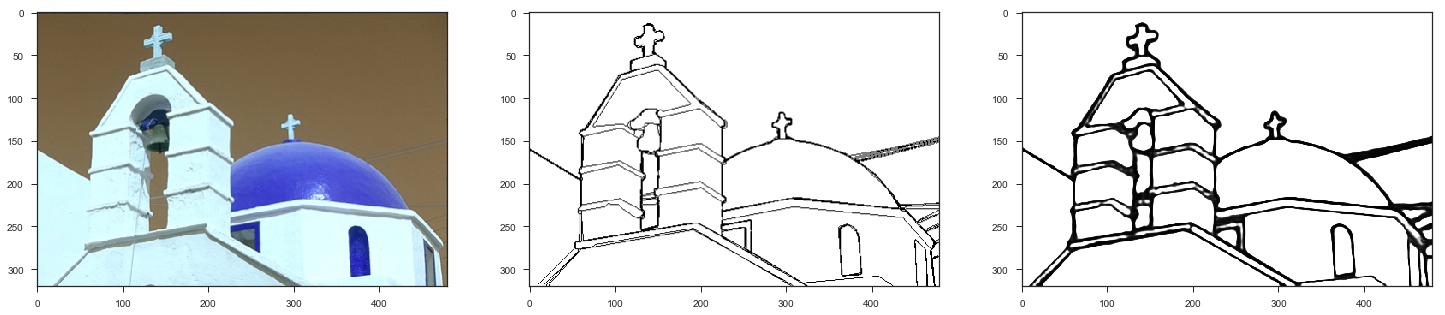

In [8]:
y_pred = model_unet_fuse.predict(X_train[18].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
np.savetxt(RESULT_PATH + '/sample_pred_HED.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.9] = 1
# y_pred[y_pred <= 0.1] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_train[18], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_train[18].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()

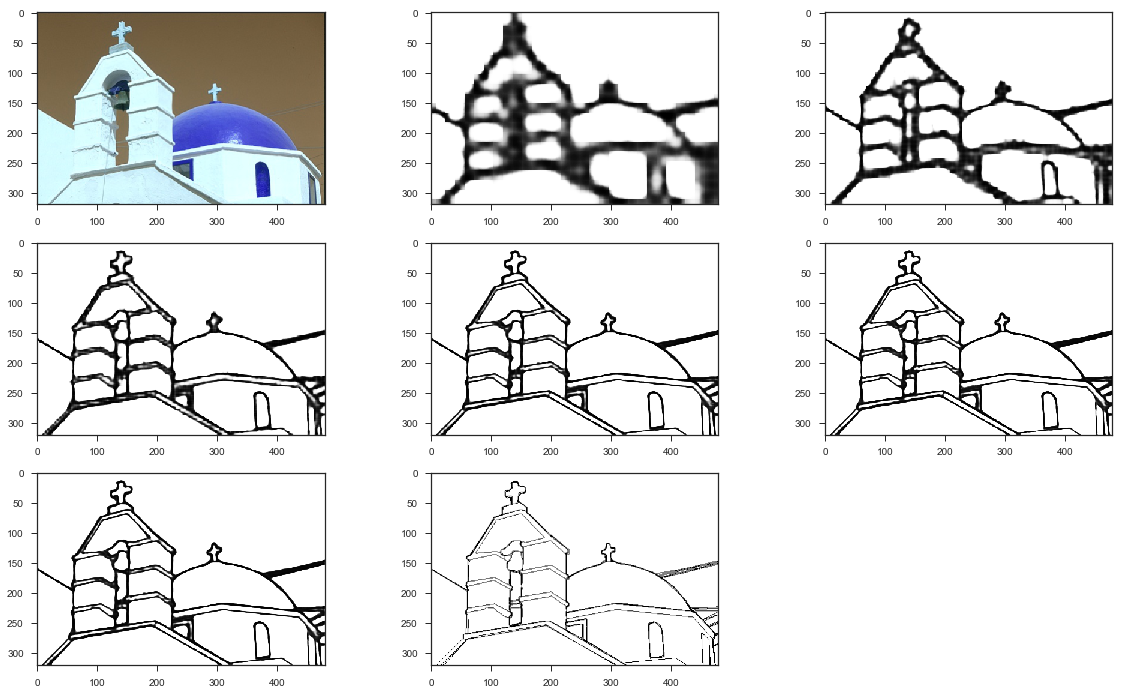

In [15]:
y_pred = model_unet_fuse.predict(X_train[18].reshape((-1,320,480,3)))
plt.figure(figsize=(20, 12))
for i in range(0, 8):
    plt.subplot(3, 3, i+1)
    if i == 0:
        plt.imshow(X_train[18], cmap='binary')
    elif i == 7:
        plt.imshow(y_train[18].reshape((320, 480)), cmap='binary')
    else:
        plt.imshow(y_pred[i-1].reshape((320, 480)), cmap='binary')
plt.show()

In [18]:
model_unet_fuse.save_weights(WEIGHT_PATH + 'UNET_fuse_weight.h5')
model_unet_fuse.save(MODEL_PATH + 'UNET_fuse_model.h5')
model_json = model_unet_fuse.to_json()
with open(MODEL_PATH + 'UNET_fuse_model.json', "w") as json_file:
    json_file.write(model_json)

In [20]:
model_unet_load = u_net_fuse(input_shape=(320, 480, 3))
model_unet_load.load_weights('/media/tulan/Linux/Pycharm/Image_Edge/weight/UNET_fuse_weight.h5')

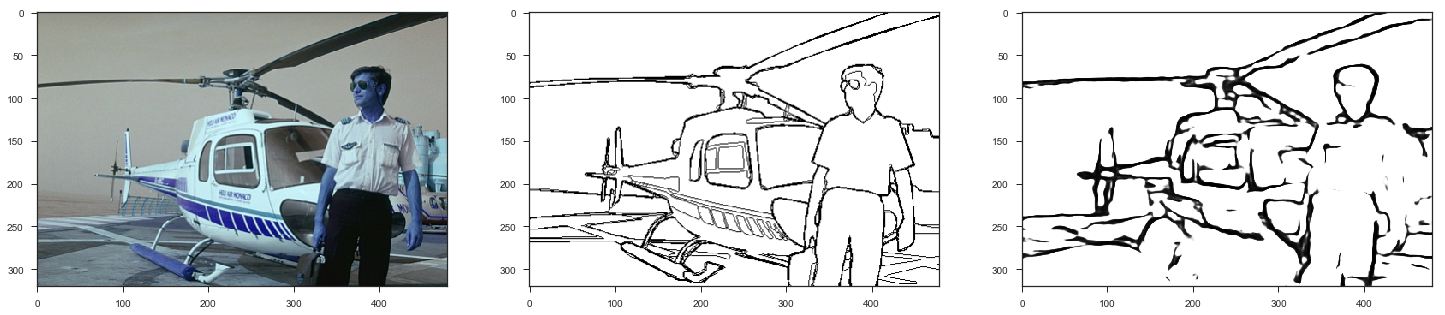

In [26]:
y_pred = model_unet_load.predict(X_test[44].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
# np.savetxt(RESULT_PATH + '/sample_pred.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.5] = 1
# y_pred[y_pred < 0.5] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_test[44], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_test[44].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()